In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import os, yaml
from regions import Regions, CircleSkyRegion
from scipy.stats import norm
from copy import deepcopy

# Uncomment if SimBMVtool not in directory
# import sys
# path_SimBMVtool = '<path_to_SimBMVtool>'
# sys.path.append(path_SimBMVtool)
# Uncomment if SimBMVtool not in directory

# Uncomment if SimBMVtool not in directory
import sys
path_SimBMVtool = '/Users/carrasco/Prog/gammapy/icrc25/SimBMVtool_icrc'
sys.path.append(path_SimBMVtool)

from SimBMVtool.external_bmv_creator import ExternalBMVCreator
from SimBMVtool.toolbox import (
    any2pickle,
    pickle2any,
    get_data_store,
    get_dfobs_table,
    load_yaml,
    get_skymaps_dict,
    plot_skymap_from_dict
)

path_config = './config_3d_analysis.yaml'

In [ ]:
# Uncomment if you haven't downloaded gammapy datasets and update the path in config_simu.yaml
# It is NEEDED for the catalogs and for the example dataset

# !gammapy download datasets
# !conda env config vars set GAMMAPY_DATA=$PWD/gammapy-datasets/2.0

# You may need to restart the environment

In [2]:
# Check the files in the directory following config['paths']['path_data']
with open(path_config, 'r') as file:
    config = yaml.safe_load(file)
path_data = config["paths"]["path_data"]
obs_pattern = config["data"]["obs_pattern"]
source_name = config["source"]["catalog_name"]

data_store = get_data_store(path_data,obs_pattern)
dfobs_table = get_dfobs_table(data_store.obs_table)

print("Objects in datastore: ", list(dfobs_table.OBJECT))
display(dfobs_table)

# Look for the source in case there are several in the table.
# The objects are compared with lower case and no space to account for different names
is_source = dfobs_table.OBJECT.str.lower().str.replace(' ', '') == source_name.lower().replace(' ','')
display(dfobs_table.loc[is_source].reset_index())

Objects in datastore:  ['MSH15-52', 'MSH15-52', 'custom', '3C 273', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'Cen A', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'MSH 15-5-02', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'RXJ 1713.7-3946', 'GRB 040425 north', 'SN 1006', 'G346.1+0.0', 'G346.8+0.0', 'G347.5+0.0', '3C 273', 'PKS 2316-423', 'PKS 2316-423', 'Q J22548-2725', '1ES 2343-151', '1ES 0145+138', 'GX 339-4', 'Pictor A', 'NGC 1068', 'PSR J0437-4715', 'NGC 1068', 'PKS 0548-322', '3C 120', 'Crab Nebula', 'Crab Nebula', 'Crab Nebula', 'EXO 0556.4-3838', 'Crab Nebula', '3C 120', '3C 120', 'SN 1987A', '3C 273', '3C 273', '3C 273', 'Sco X-1', 'Arp 220', 'Arp 220', 'Kepler SN

TSTART        TSTOP  ONTIME     LIVETIME     DEADC TELESCOP  \
OBS_ID                                                                     
20136   101962602.0  101964284.0  1682.0  1521.026855  0.904297     HESS   
20137   101964441.0  101965343.0   902.0   819.205383  0.908210     HESS   
20151   102047232.0  102048915.0  1683.0  1530.479004  0.909376     HESS   
20275   103665036.0  103666719.0  1683.0  1525.844727  0.906622     HESS   
20282   103678269.0  103679956.0  1687.0  1543.323120  0.914833     HESS   
...             ...          ...     ...          ...       ...      ...   
47803   241560121.0  241561809.0  1688.0  1566.936890  0.928280     HESS   
47804   241561944.0  241563633.0  1689.0  1560.271729  0.923784     HESS   
47827   241644720.0  241646408.0  1688.0  1575.551514  0.933384     HESS   
47828   241646545.0  241648232.0  1687.0  1562.428833  0.926158     HESS   
47829   241648358.0  241650046.0  1688.0  1559.607178  0.923938     HESS   

            RA_PNT    DEC_PNT    GLON_PNT   GLAT_PNT  ...  \
OBS_ID                                                ...   
20136   228.612500 -58.771667  320.567556  -0.885703  ...   
20137   228.612500 -59.771667  320.047260  -1.739775  ...   
20151   228.612500 -58.771667  320.567556  -0.885703  ...   
20275   187.277917   2.552389  289.715550  64.849684  ...   
20282   228.612500 -58.771667  320.567556  -0.885703  ...   
...            ...        ...         ...        ...  ...   
47803   329.137967 -30.225556   17.639971 -51.748708  ...   
47804   329.716667 -29.725556   18.541180 -52.188049  ...   
47827   330.295367 -30.225556   17.818925 -52.742736  ...   
47828   329.137967 -30.225556   17.639971 -51.748708  ...   
47829   329.716667 -30.725556   16.917834 -52.297617  ...   

                                          EVENTS_FILENAME EVENT_COUNT  \
OBS_ID                                                                  
20136   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11243   
20137   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...        5693   
20151   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       10722   
20275   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       10646   
20282   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11063   
...                                                   ...         ...   
47803   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...        6243   
47804   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...        6445   
47827   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...        5703   
47828   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...        6030   
47829   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...        6469   

                CALDB            IRF  \
OBS_ID                                 
20136   NOT AVAILABLE  NOT AVAILABLE   
20137   NOT AVAILABLE  NOT AVAILABLE   
20151   NOT AVAILABLE  NOT AVAILABLE   
20275   NOT AVAILABLE  NOT AVAILABLE   
20282   NOT AVAILABLE  NOT AVAILABLE   
...               ...            ...   
47803   NOT AVAILABLE  NOT AVAILABLE   
47804   NOT AVAILABLE  NOT AVAILABLE   
47827   NOT AVAILABLE  NOT AVAILABLE   
47828   NOT AVAILABLE  NOT AVAILABLE   
47829   NOT AVAILABLE  NOT AVAILABLE   

                                             IRF_FILENAME MJDREFI   MJDREFF  \
OBS_ID                                                                        
20136   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...   51910  0.000743   
20137   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...   51910  0.000743   
20151   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...   51910  0.000743   
20275   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...   51910  0.000743   
20282   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...   51910  0.000743   
...                                                   ...     ...       ...   
47803   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...   51910  0.000743   
47804   gammapy-datasets/2.0/hess-dl3-dr1/data/h

OBS_ID       TSTART        TSTOP  ONTIME     LIVETIME     DEADC TELESCOP  \
0    20282  103678269.0  103679956.0  1687.0  1543.323120  0.914833     HESS   
1    20283  103680087.0  103681770.0  1683.0  1547.825317  0.919682     HESS   
2    20301  103764878.0  103766561.0  1683.0  1534.062622  0.911505     HESS   
3    20302  103766698.0  103768380.0  1682.0  1535.347778  0.912811     HESS   
4    20303  103768520.0  103770202.0  1682.0  1535.160645  0.912700     HESS   
5    20322  103850925.0  103852607.0  1682.0  1529.792480  0.909508     HESS   
6    20323  103852744.0  103854426.0  1682.0  1530.117432  0.909701     HESS   
7    20324  103854560.0  103856243.0  1683.0  1527.872192  0.907827     HESS   
8    20325  103856373.0  103858055.0  1682.0  1529.394775  0.909272     HESS   
9    20343  103936478.0  103938160.0  1682.0  1529.018066  0.909048     HESS   
10   20344  103938293.0  103939975.0  1682.0  1529.142944  0.909122     HESS   
11   20345  103940106.0  103941789.0  1683.0  1530.673096  0.909491     HESS   
12   20346  103941920.0  103943603.0  1683.0  1528.990234  0.908491     HESS   
13   20365  104023534.0  104025217.0  1683.0  1543.645264  0.917199     HESS   
14   20366  104025356.0  104027039.0  1683.0  1539.964233  0.915011     HESS   
15   20367  104027169.0  104028851.0  1682.0  1544.367676  0.918173     HESS   
16   20368  104028983.0  104030666.0  1683.0  1541.970459  0.916203     HESS   

      RA_PNT    DEC_PNT    GLON_PNT  ...  \
0   228.6125 -58.771667  320.567556  ...   
1   228.6125 -59.771667  320.047260  ...   
2   228.6125 -58.771667  320.567556  ...   
3   228.6125 -59.771667  320.047260  ...   
4   228.6125 -58.771667  320.567556  ...   
5   228.6125 -59.771667  320.047260  ...   
6   228.6125 -58.771667  320.567556  ...   
7   228.6125 -59.771667  320.047260  ...   
8   228.6125 -58.771667  320.567556  ...   
9   228.6125 -58.771667  320.567556  ...   
10  228.6125 -59.771667  320.047260  ...   
11  228.6125 -58.771667  320.567556  ...   
12  228.6125 -59.771667  320.047260  ...   
13  228.6125 -59.771667  320.047260  ...   
14  228.6125 -58.771667  320.567556  ...   
15  228.6125 -59.771667  320.047260  ...   
16  228.6125 -58.771667  320.567556  ...   

                                      EVENTS_FILENAME EVENT_COUNT  \
0   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11063   
1   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...        7628   
2   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11624   
3   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11794   
4   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11803   
5   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       12925   
6   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       13367   
7   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       12822   
8   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       12878   
9   gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       12590   
10  gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       12738   
11  gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       12582   
12  gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       12372   
13  gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11059   
14  gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       11344   
15  gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       10763   
16  gammapy-datasets/2.0/hess-dl3-dr1/data/hess_dl...       10820   

            CALDB            IRF  \
0   NOT AVAILABLE  NOT AVAILABLE   
1   NOT AVAILABLE  NOT AVAILABLE   
2   NOT AVAILABLE  NOT AVAILABLE   
3   NOT AVAILABLE  NOT AVAILABLE   
4   NOT AVAILABLE  NOT AVAILABLE   
5   NOT AVAILABLE  NOT AVAILABLE   
6   NOT AVAILABLE  NOT AVAILABLE   
7   NOT AVAILABLE  NOT AVAILABLE   
8   NOT AVAILABLE  NOT AVAILABLE   
9   NOT AVAILABLE  NOT AVAILABLE   
10  NOT AVAILABLE  NOT AVAILABLE   
11  NOT AVAILABLE  NOT AVAILABLE   
12  NOT AVAILABLE  NOT AVAILABLE   
13  NOT AVAILABLE  NOT 

In [3]:
realbmv = ExternalBMVCreator(path_config, real_data=True)
do_baccmod=True
if do_baccmod: realbmv.do_baccmod()
else:
    realbmv.load_observation_collection(from_index=True)
    realbmv.load_output_background_irfs()
display(realbmv.obs_table)

# Loading the observations can give a lot of warning regarding missing HDUs depending on how the data store is created.
# The tool handles that and will retrieve them to add them back.

paths: {'path_data': './gammapy-datasets/2.0/hess-dl3-dr1/data', 'gammapy_catalog': './gammapy-datasets/2.0/catalogs/gammacat/gammacat.fits.gz', 'models': './SimBMVtool/models.yaml', 'output_dir': './outputs', 'subdir': 'msh1552_hess'}
data: {'run_list': [20282, 20283, 20301, 20302, 20303, 20322, 20323, 20324, 20325, 20343, 20344, 20345, 20346, 20365, 20366, 20367, 20368], 'obs_pattern': 'hess_dl3_*', 'cos_zenith_bin_edges': [-0.0, 0.25, 0.5, 0.75, 1.0], 'cos_zenith_bin_centers': [0.125, 0.375, 0.625, 0.875]}
source: {'catalog_name': 'MSH 15-5-02', 'coordinates': {'ra': 228.32080078, 'dec': -59.08169937}, 'exclusion_region': {'shape': 'n_shapes', 'safe_radius_from_map_center': 1.8, 'regions': {'ellipse_1': {'ra': 228.4, 'dec': -59.171, 'width': 0.8, 'height': 0.7, 'angle': 101, 'is_source': True}}}}
background: {'maker': {'correlation_radius': 0.15, 'correlate_off': True, 'ring': {'internal_ring_radius': 0.15, 'width': 0.25}, 'fov': {'method': 'scale', 'spectral_model': 'pl-norm'}}}
ac

HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE A

Available sources:  ['00:29:18 -73:00:00' '00:35:50 -71:41:20' '1ES 0145+138' '1ES 0414+009'
 '1ES 2343-151' '3C 120' '3C 273' '47 Tuc NW' 'AE Aqr' 'Arp 220' 'Cen A'
 'Crab Nebula' 'EXO 0556.4-3838' 'G346.1+0.0' 'G346.8+0.0' 'G347.5+0.0'
 'GRB 040425 north' 'GX 339-4' 'Kepler SNR' 'MSH 15-5-02' 'MSH15-52'
 'NGC 1068' 'NGC 1399' 'NGC 253' 'PKS 0548-322' 'PKS 2155-304'
 'PKS 2316-423' 'PSR J0437-4715' 'Pictor A' 'Q J22548-2725'
 'RXJ 1713.7-3946' 'SN 1006' 'SN 1987A' 'Sco X-1' 'custom']
105 available runs:  [20136 20137 20151 20275 20282 20283 20301 20302 20303 20322 20323 20324
 20325 20326 20327 20339 20343 20344 20345 20346 20349 20350 20365 20366
 20367 20368 20396 20397 20421 20422 20517 20518 20519 20521 20561 20734
 20898 20899 20900 20915 21613 21753 21807 21824 21851 22022 22593 22997
 23040 23077 23143 23246 23523 23526 23559 23573 23592 23635 23651 23736
 25345 25443 25511 26077 26791 26827 26850 26964 27044 27121 27939 27987
 28341 28967 28981 29024 29072 29118 29177 29433 29

HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'BACKGROUND' not found
HDU 'EFFECTIVE A

17 selected runs:  [20282 20283 20301 20302 20303 20322 20323 20324 20325 20343 20344 20345
 20346 20365 20366 20367 20368]
Total livetime: 7.3 h


count
Ebin                     
(0.5, 0.7671]     17529.0
(0.7671, 1.1768]   7677.0
(1.1768, 1.8053]   4309.0
(1.8053, 2.7696]   2747.0
(2.7696, 4.2489]   1651.0
(4.2489, 6.5184]   1132.0
(6.5184, 10.0]      777.0

/Users/carrasco/miniconda3/envs/simbmvtool_paper/lib/python3.11/site-packages/baccmod/modeling.py:44: RuntimeWarning: invalid value encountered in log
  return -mu + x * np.log(mu) - log_factorial_x
/Users/carrasco/miniconda3/envs/simbmvtool_paper/lib/python3.11/site-packages/baccmod/modeling.py:44: RuntimeWarning: divide by zero encountered in log
  return -mu + x * np.log(mu) - log_factorial_x
/Users/carrasco/miniconda3/envs/simbmvtool_paper/lib/python3.11/site-packages/baccmod/modeling.py:44: RuntimeWarning: invalid value encountered in multiply
  return -mu + x * np.log(mu) - log_factorial_x
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found


Obs collection loading pattern: _with_bkg_3d_fit_n_shapes_Ebins_7_offsetbins_8_offset_max_3.0_exclurad_0.8


HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFECTIVE AREA' not found
HDU 'ENERGY DISPERSION' not found
HDU 'EFFECTIVE AREA' not found
HDU 'EFFE

<ObservationTable length=17>
OBS_ID    TSTART      TSTOP     ONTIME ... TIMEUNIT TIMESYS TIMEREF
            s           s         s    ...                         
int64    float64     float64   float64 ...  bytes1   bytes2  bytes5
------ ----------- ----------- ------- ... -------- ------- -------
 20282 103678269.0 103679956.0  1687.0 ...        s      TT   local
 20283 103680087.0 103681770.0  1683.0 ...        s      TT   local
 20301 103764878.0 103766561.0  1683.0 ...        s      TT   local
 20302 103766698.0 103768380.0  1682.0 ...        s      TT   local
 20303 103768520.0 103770202.0  1682.0 ...        s      TT   local
 20322 103850925.0 103852607.0  1682.0 ...        s      TT   local
 20323 103852744.0 103854426.0  1682.0 ...        s      TT   local
 20324 103854560.0 103856243.0  1683.0 ...        s      TT   local
 20325 103856373.0 103858055.0  1682.0 ...        s      TT   local
 20343 103936478.0 103938160.0  1682.0 ...        s      TT   local
 20344 103938293.0 103939975.0  1682.0 ...        s      TT   local
 20345 103940106.0 103941789.0  1683.0 ...        s      TT   local
 20346 103941920.0 103943603.0  1683.0 ...        s      TT   local
 20365 104023534.0 104025217.0  1683.0 ...        s      TT   local
 20366 104025356.0 104027039.0  1683.0 ...        s      TT   local
 20367 104027169.0 104028851.0  1682.0 ...        s      TT   local
 20368 104028983.0 104030666.0  1683.0 ...        s      TT   local

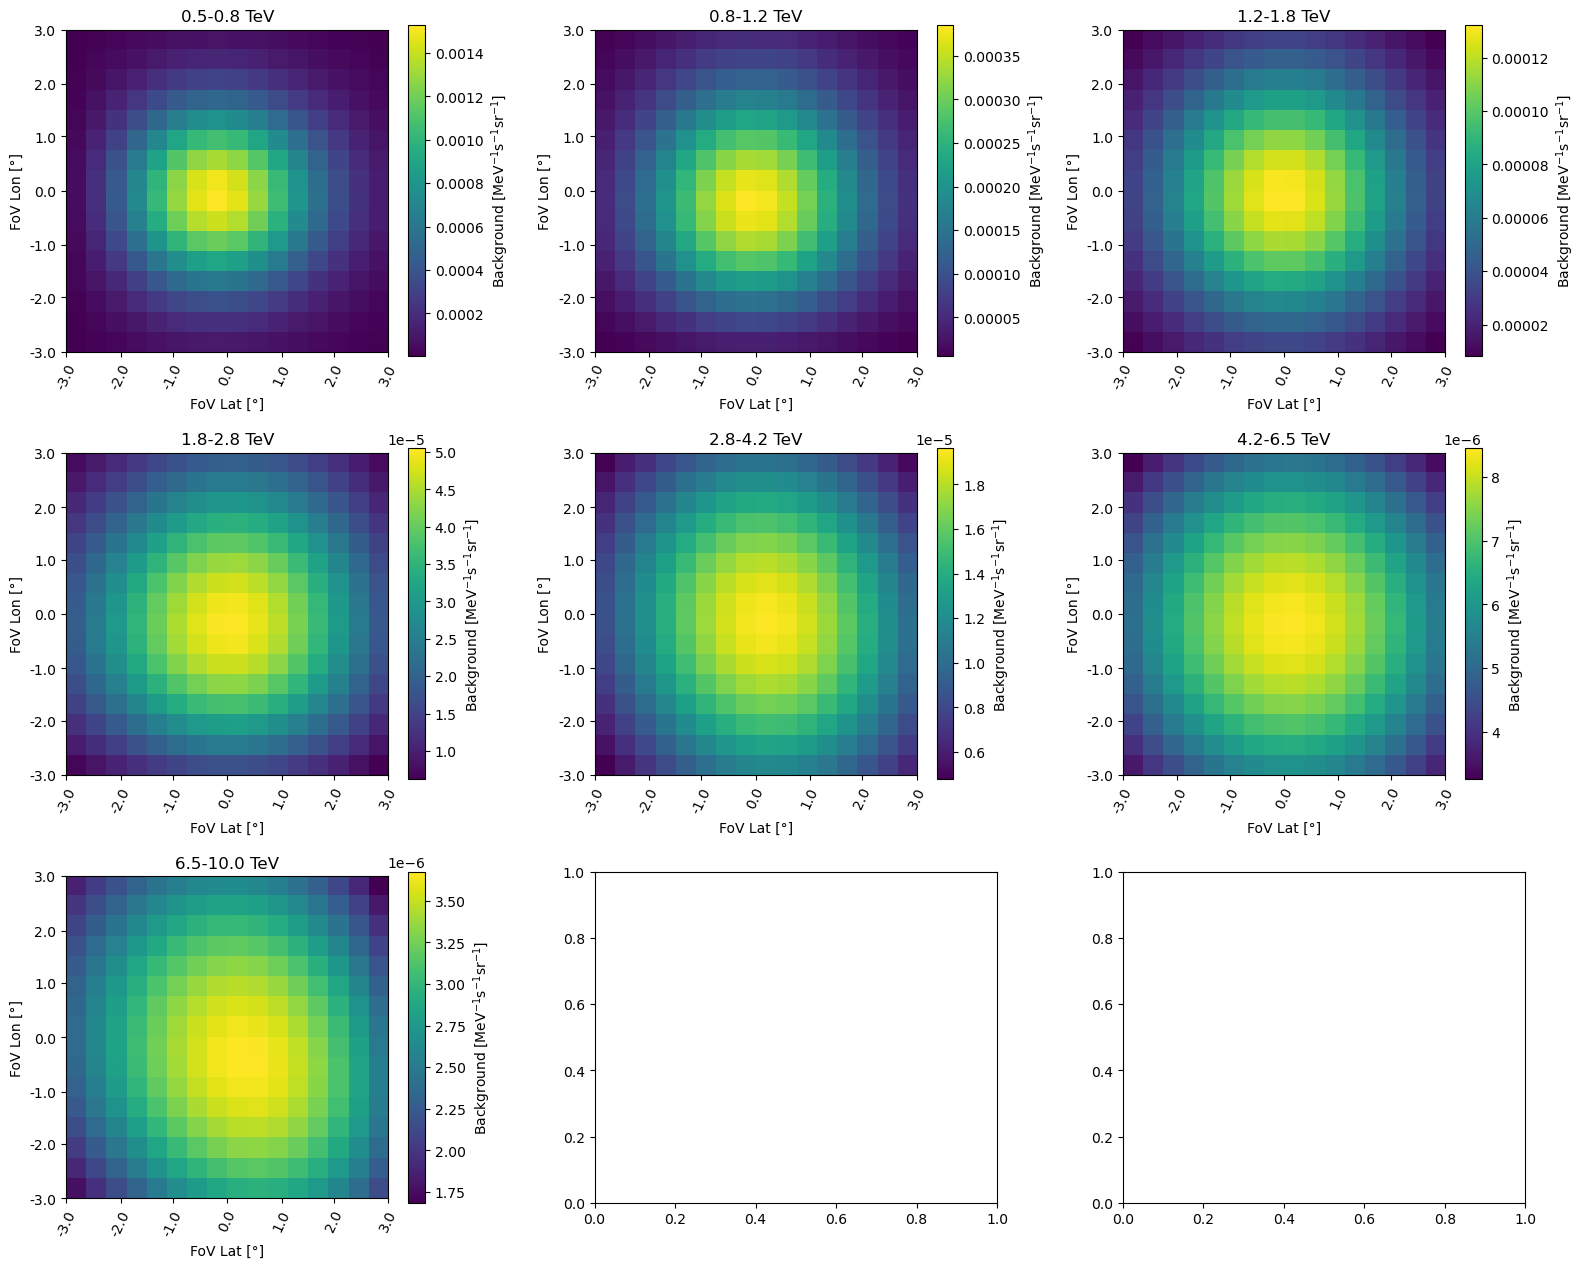

In [4]:
realbmv.plot_model(data='acceptance',irf='output', i_irf=0)

paths: {'path_data': './gammapy-datasets/2.0/hess-dl3-dr1/data', 'gammapy_catalog': './gammapy-datasets/2.0/catalogs/gammacat/gammacat.fits.gz', 'models': './SimBMVtool/models.yaml', 'output_dir': './outputs', 'subdir': 'msh1552_hess'}
data: {'run_list': [20282, 20283, 20301, 20302, 20303, 20322, 20323, 20324, 20325, 20343, 20344, 20345, 20346, 20365, 20366, 20367, 20368], 'obs_pattern': 'hess_dl3_*', 'cos_zenith_bin_edges': [-0.0, 0.25, 0.5, 0.75, 1.0], 'cos_zenith_bin_centers': [0.125, 0.375, 0.625, 0.875]}
source: {'catalog_name': 'MSH 15-5-02', 'coordinates': {'ra': 228.32080078, 'dec': -59.08169937}, 'exclusion_region': {'shape': 'n_shapes', 'safe_radius_from_map_center': 1.8, 'regions': {'ellipse_1': {'ra': 228.4, 'dec': -59.171, 'width': 0.8, 'height': 0.7, 'angle': 101, 'is_source': True}}}}
background: {'maker': {'correlation_radius': 0.15, 'correlate_off': True, 'ring': {'internal_ring_radius': 0.15, 'width': 0.25}, 'fov': {'method': 'scale', 'spectral_model': 'pl-norm'}}}
ac

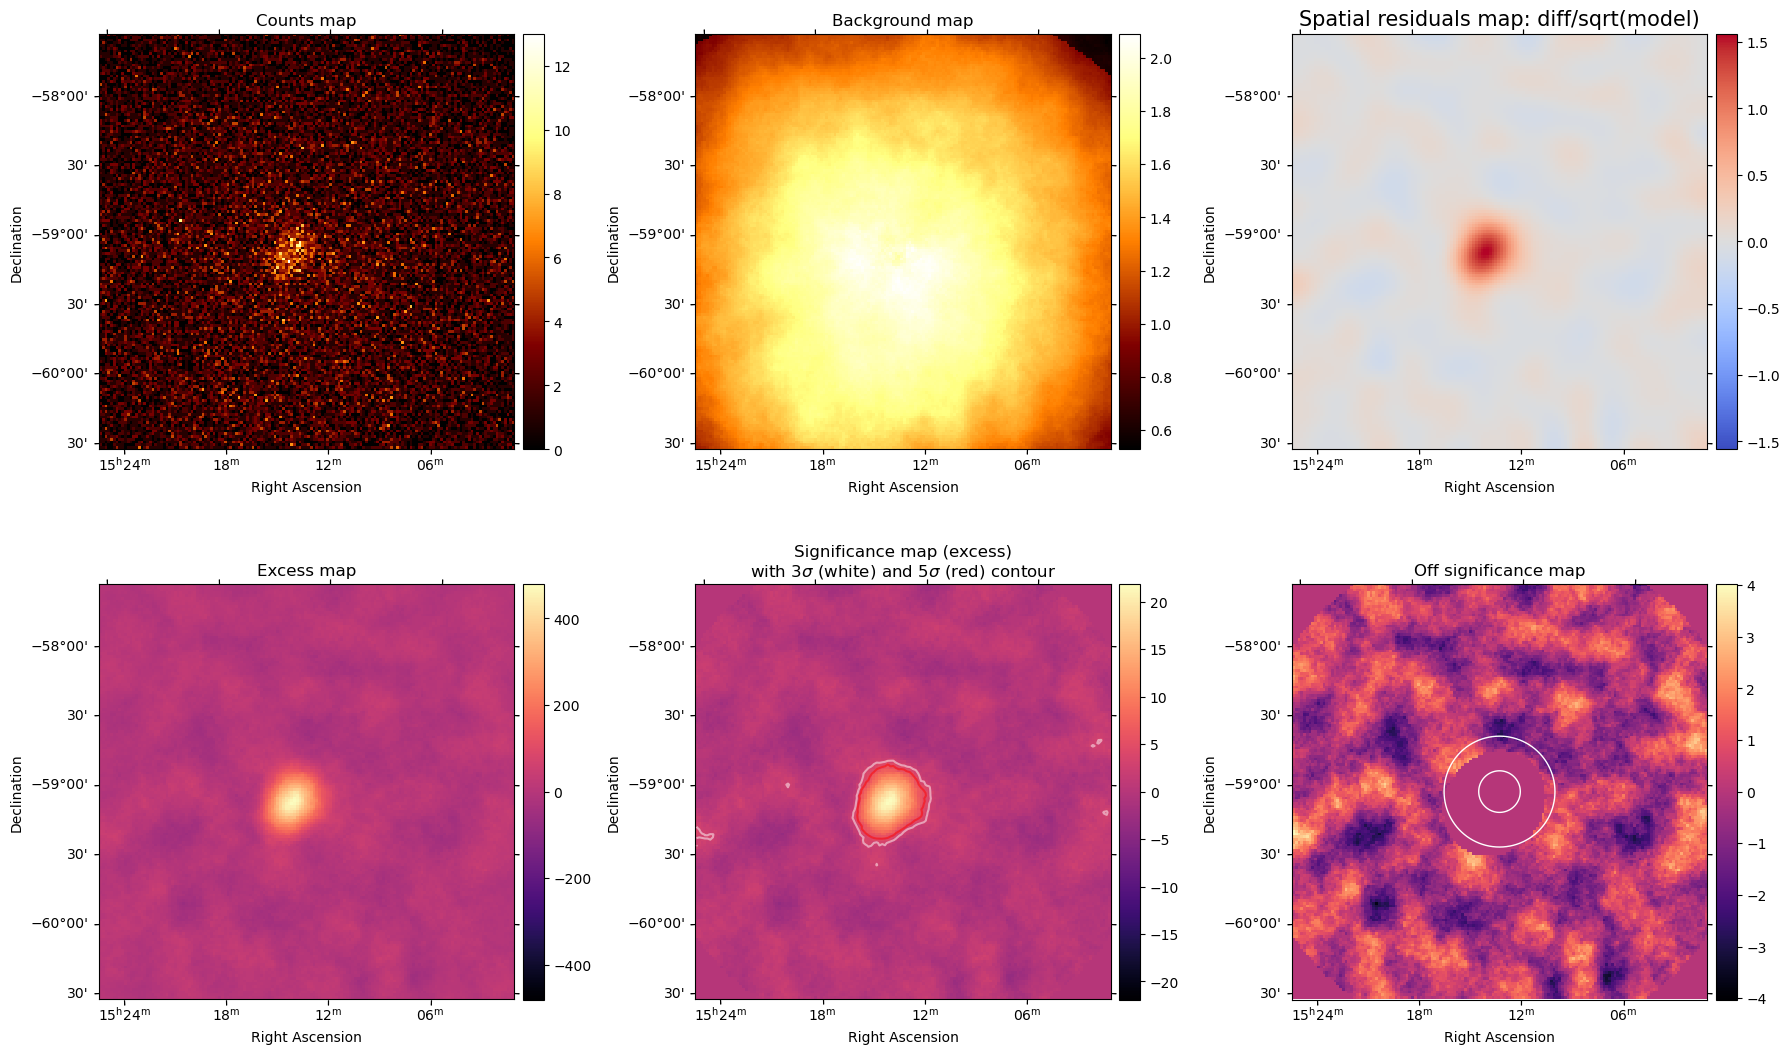

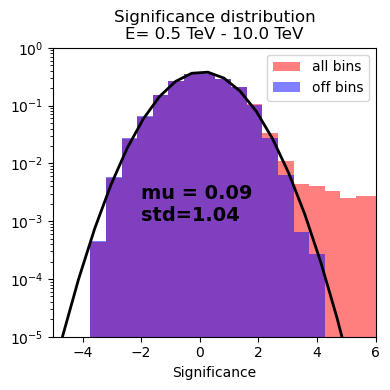

Using stored unstacked datasets
FoV background method is applied
Background maker applied run-wise
mu =  0.0231394859443177  std=  1.6292564058910144


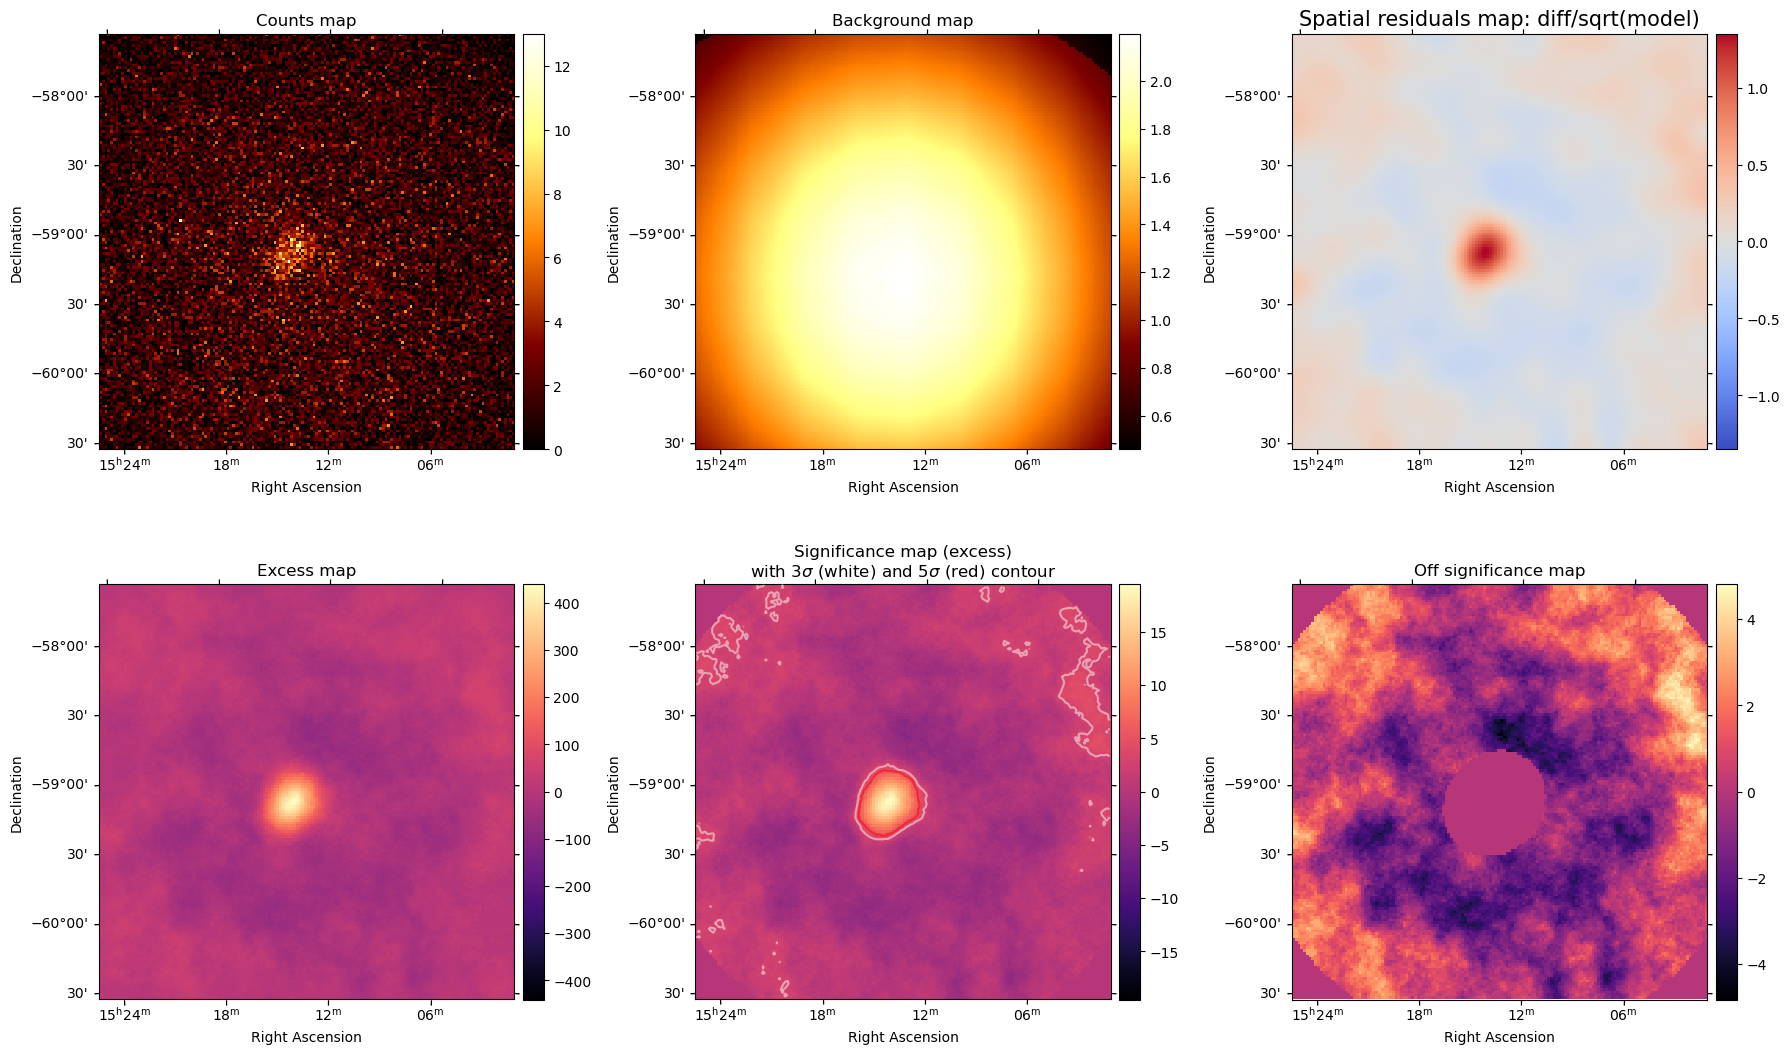

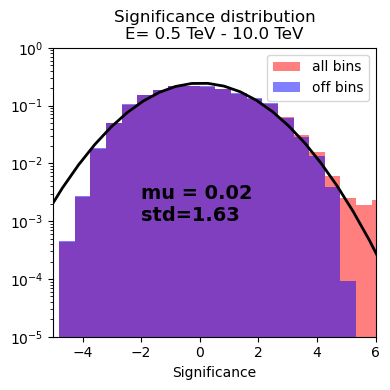

In [5]:
realbmv.init_config_bmv(path_config)
e_min, e_max = realbmv.e_min, realbmv.e_max
nbinE_per_decade = 4
offset_max = 2.5 * u.deg
width = (3,3)
realbmv.axis_info_dataset = [e_min, e_max, nbinE_per_decade, offset_max, width]
realbmv.source_info[0] = SkyCoord(ra=228.4 *u.deg, dec=-59.2*u.deg, frame="icrs") # Better center position for the map compared to the catalog position

realbmv.plot_skymaps('ring')
plt.show()

realbmv.plot_skymaps('FoV', 'stored') # Use stored unstacked datasets instead of recomputing them, which is the part that takes a long time for large datasets
plt.show()

In [7]:
# We see issues with the FoVBackground when looking at the off significance map, not sure why yet.

In [6]:
from hl_analysis import get_models_names_list, add_model_to_models_dict
from gammapy.modeling.models import SkyModel

# You can import models to initialize the fit from the library, or just declare it manually
realbmv.models_dict = load_yaml(realbmv.path_models)
ref_source_model = SkyModel.from_dict(realbmv.models_dict["MSH15-52"]["published"]["hess"]["models"])

n_sources = 1
same_seeds = True

# Provide one seed per component if initialized differently (same_seeds is False), else the first seed of the list is used for each component
models_seeds = [ref_source_model] # or [ref_source_model_1, ref_source_model_2] for instance if n_sources=2 and same_seeds=False

spatial_models_to_test = ["Point", "Disk", "Ellipse", "1D Gauss", "2D Gauss"]   # "Point", "1D Gauss", "2D Gauss", "Disk", "Ellipse"
spectral_models_to_test  = ["PL"]                                               # "PL", "ECPL", "LP"

# If you want all the combinations to be tested
models_to_test_names = get_models_names_list(spatial_models_to_test,spectral_models_to_test,n_sources,same_seeds)
for name in models_to_test_names:
    print(name)

# If you don't want everything, you can give a list of model names, e.g. models_to_test_names = ["2D Gauss PL - Point ECPL"]
# You need to include a 'No source' model to compute the significance of a source detection compared to background only
# e.g.: models_to_test_names = ['No source', 'Point PL - Point PL']

models_to_test = {}
for model_name in models_to_test_names:
    add_model_to_models_dict(models_seeds, models_to_test, model_name, same_seeds)

No source
Point PL
Disk PL
Ellipse PL
1D Gauss PL
2D Gauss PL


Ring background method is applied
Background maker applied run-wise
mu =  0.08562783958165585  std=  1.038376226374916


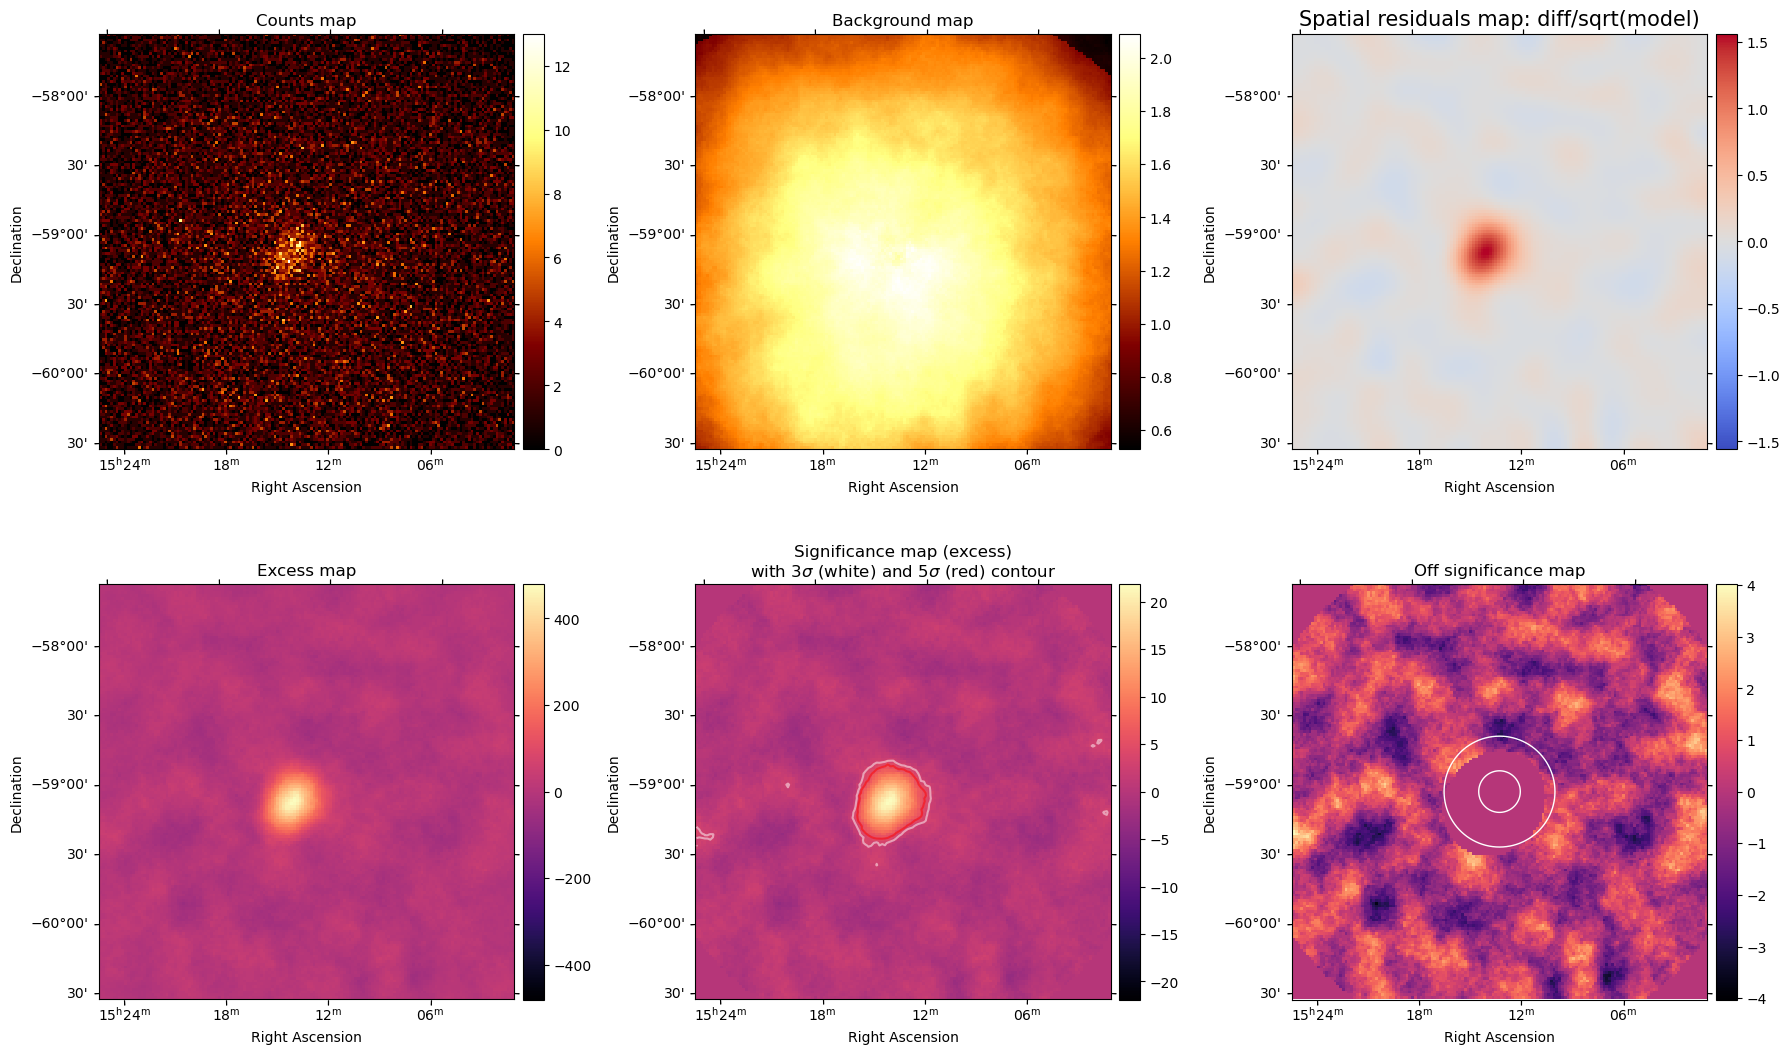

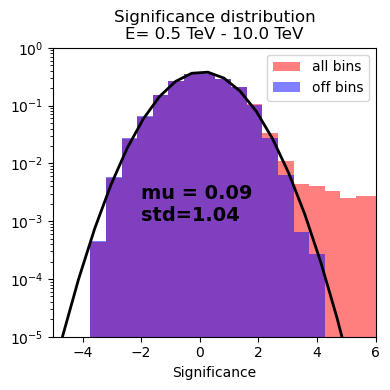

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


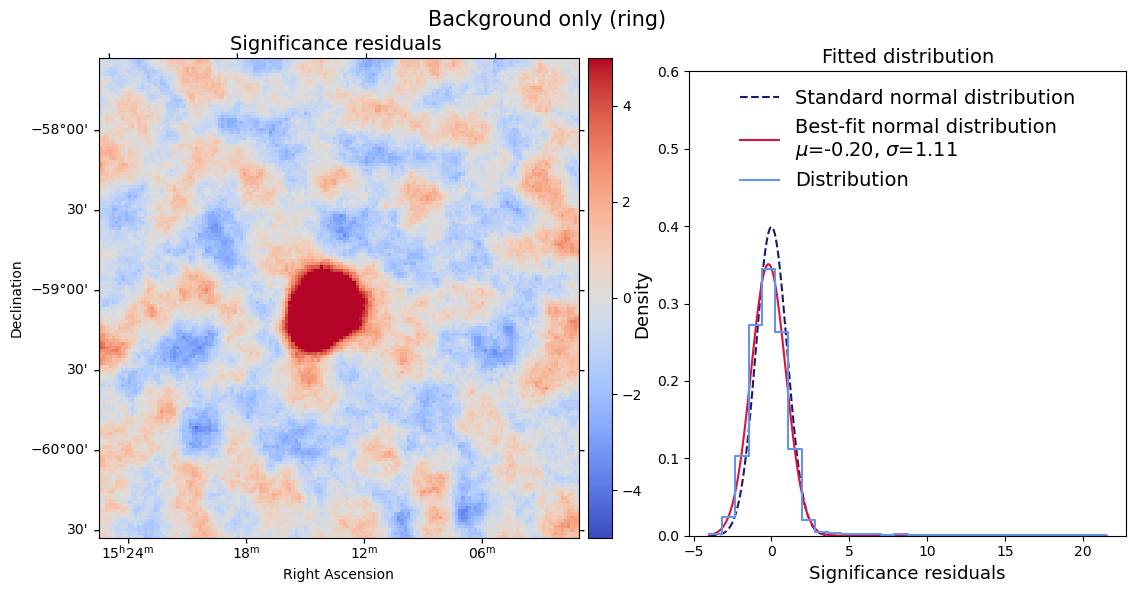

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 0.00194442 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -1.00246
W MnPosDef Added to diagonal of Error matrix a value 1.50246
W VariableMetricBuilder gdel = -5.03128
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.0255707 Requested 2e-06
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000523631 is smaller than machine limit 0.00716183 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.000523631 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000351709 is smaller than ma

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


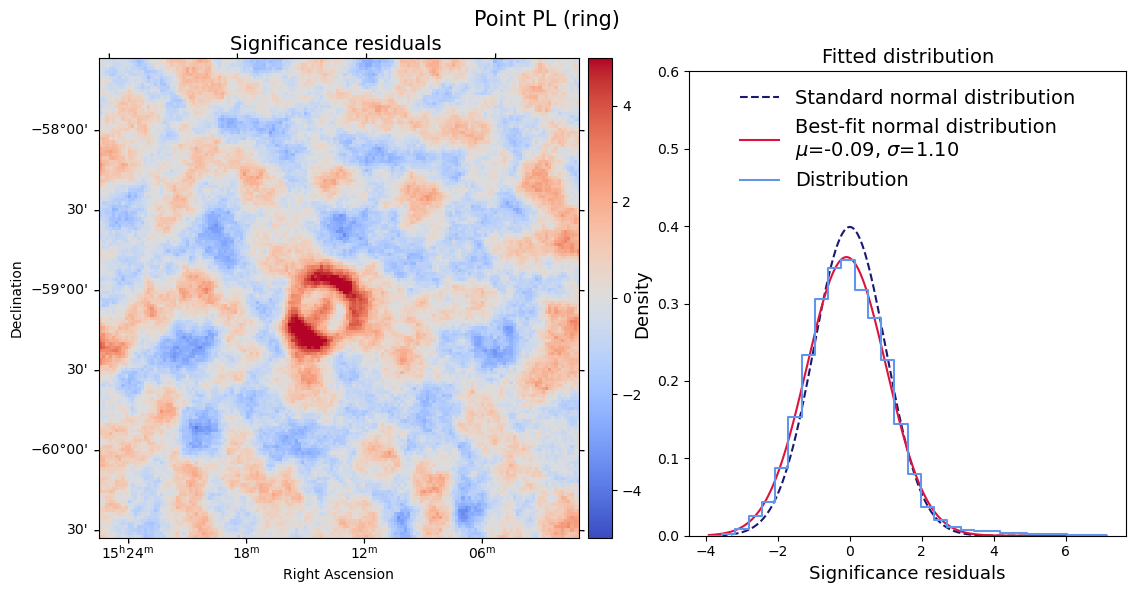

W MnPosDef Matrix forced pos-def by adding to diagonal 4.69143
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 3.99873 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -5.72031e-05
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -2.80381e-05
W MnPosDef Added to diagonal of Error matrix a value 0.500057
W VariableMetricBuilder gdel = -64854.8
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000330954 is smaller than machine limit 0.00714997 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.000330954 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W DavidonErrorUpdato

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


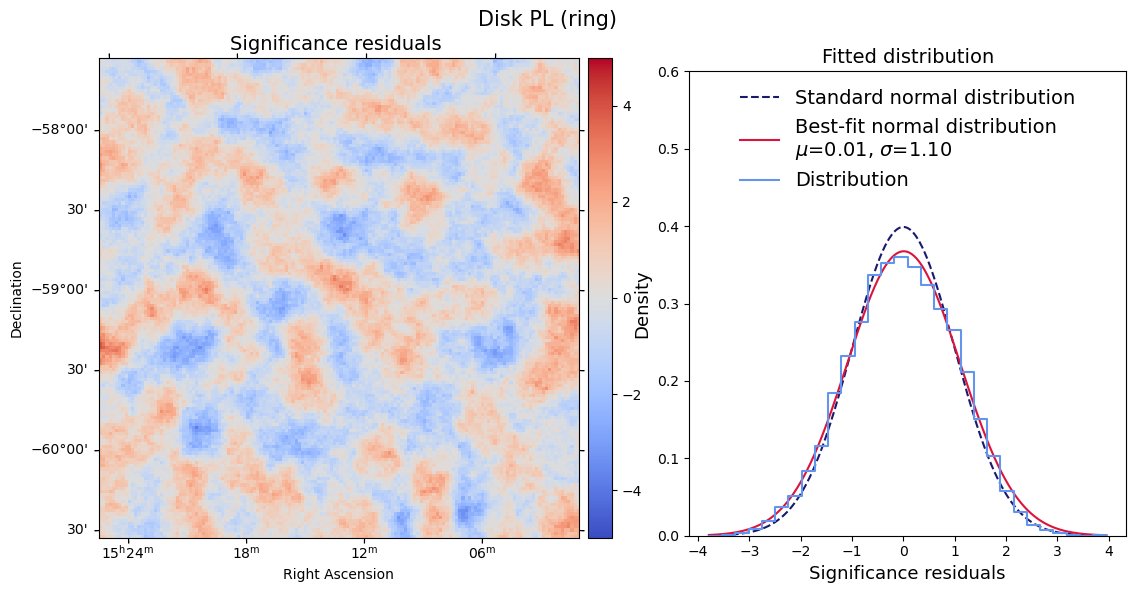

W MnPosDef Matrix forced pos-def by adding to diagonal 2.08354
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00399709 is smaller than machine limit 0.00714842 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.00399709 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000329319 is smaller than machine limit 0.00714842 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.000329319 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 0.000643162 > 0
W MnPosDef Matrix forced

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


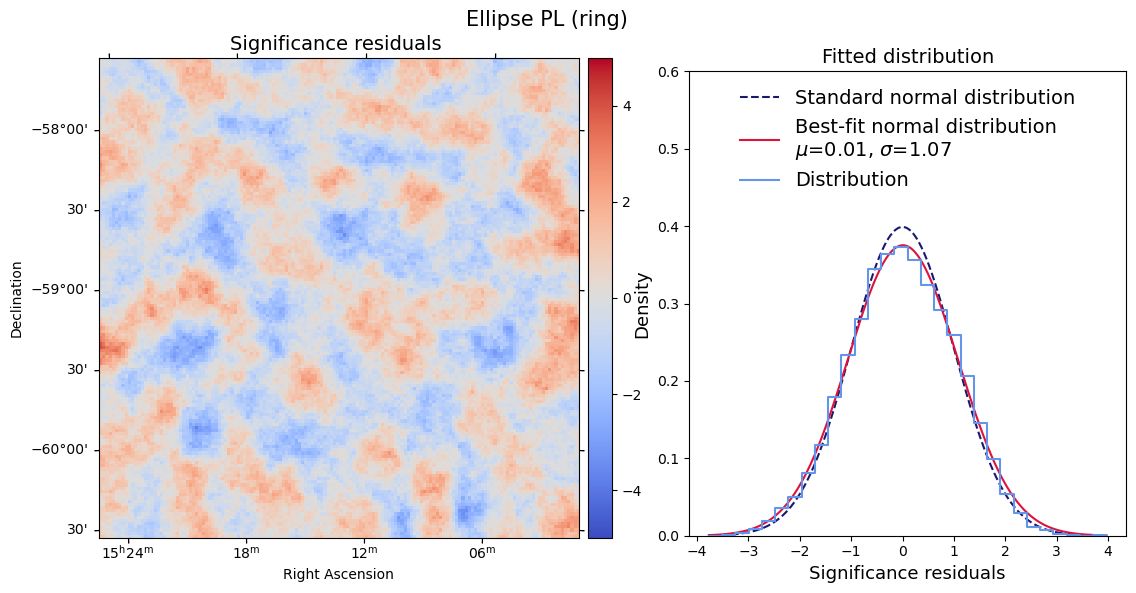

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00011357 is smaller than machine limit 0.00714992 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.00011357 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


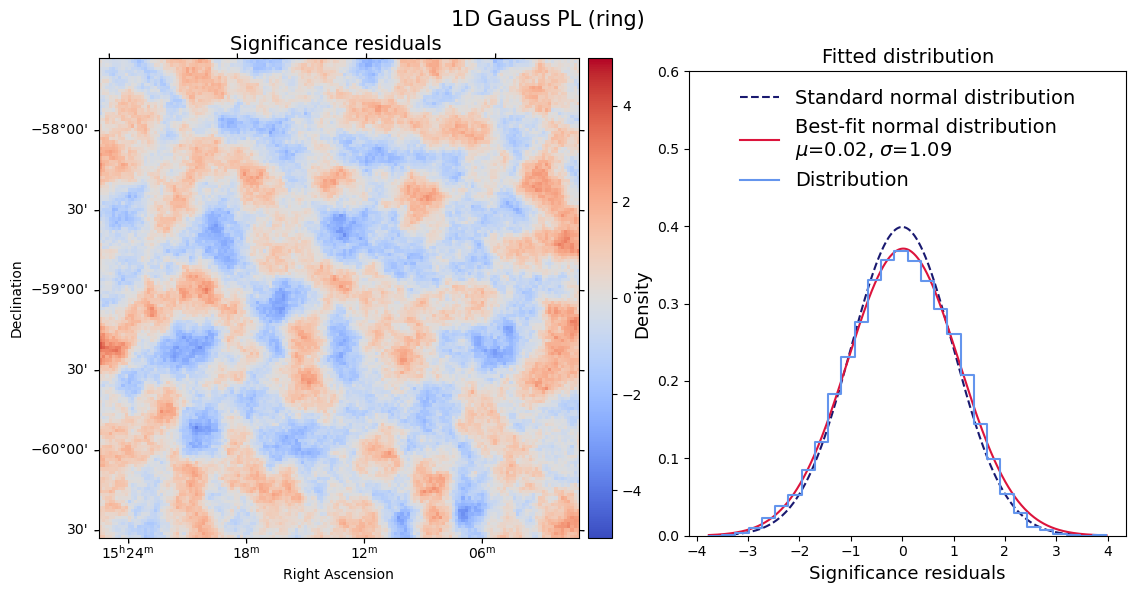

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000145772 is smaller than machine limit 0.00714982 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.000145772 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 8.29473e-05 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 10 ] = -0.283778
W MnPosDef Added to diagonal of Error matrix a value 0.783778
W VariableMetricBuilder gdel = -0.00187026
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 4.32557e-06 is smaller than machine limit 0.00714982 while 2e-06 was requested


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


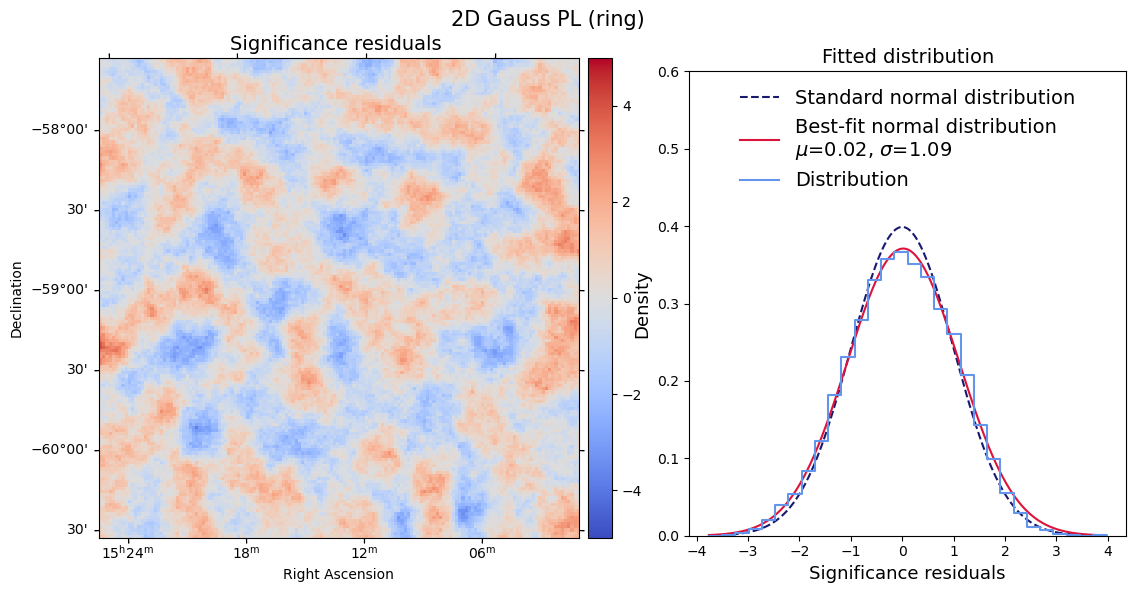

-----------------------------------------
----- Testing models as alternative -----

Tested model: Point PL
KEPT: More significant than all null models

Tested model: Disk PL
KEPT: More significant than all null models

Tested model: Ellipse PL
KEPT: More significant than all null models

Tested model: 1D Gauss PL
KEPT: More significant than all null models

Tested model: 2D Gauss PL
REMOVED: Not more significant than 1 null model

----- Testing remaining models as null -----

Tested model: Point PL
REMOVED: 4 more significant alternative models

Tested model: Disk PL
REMOVED: 1 more significant alternative models

Tested model: Ellipse PL
KEPT: No more significant alternative model

Tested model: 1D Gauss PL
KEPT: No more significant alternative model


model       wilk            AIC  relative_L
3   Ellipse PL  24.344182  119954.636373    1.000000
4  1D Gauss PL  24.027807  119975.754300    0.000026

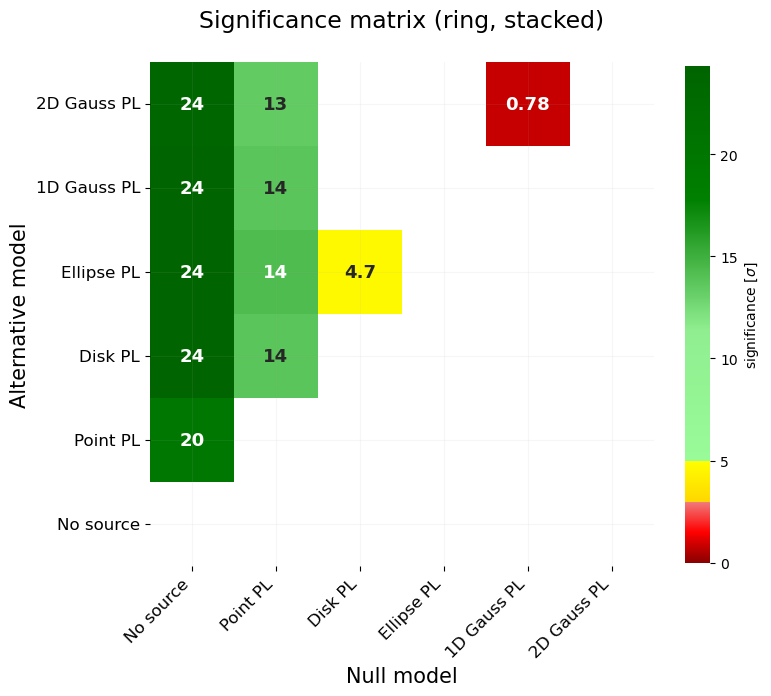

Pickle file saved at ./outputs/msh1552_hess/fit/3D_n_shapes_Ebins_7_offsetbins_8_offset_max_3.0_exclurad_0.8/hla/Eminmax_0.5_10_nbinEperdec_4_offmax_2.5_w_3_bkg_ring_FoV_fit_stacked/data/results_3d.pk
FoV background method is applied
Background maker applied run-wise
mu =  0.0231394859443177  std=  1.6292564058910144


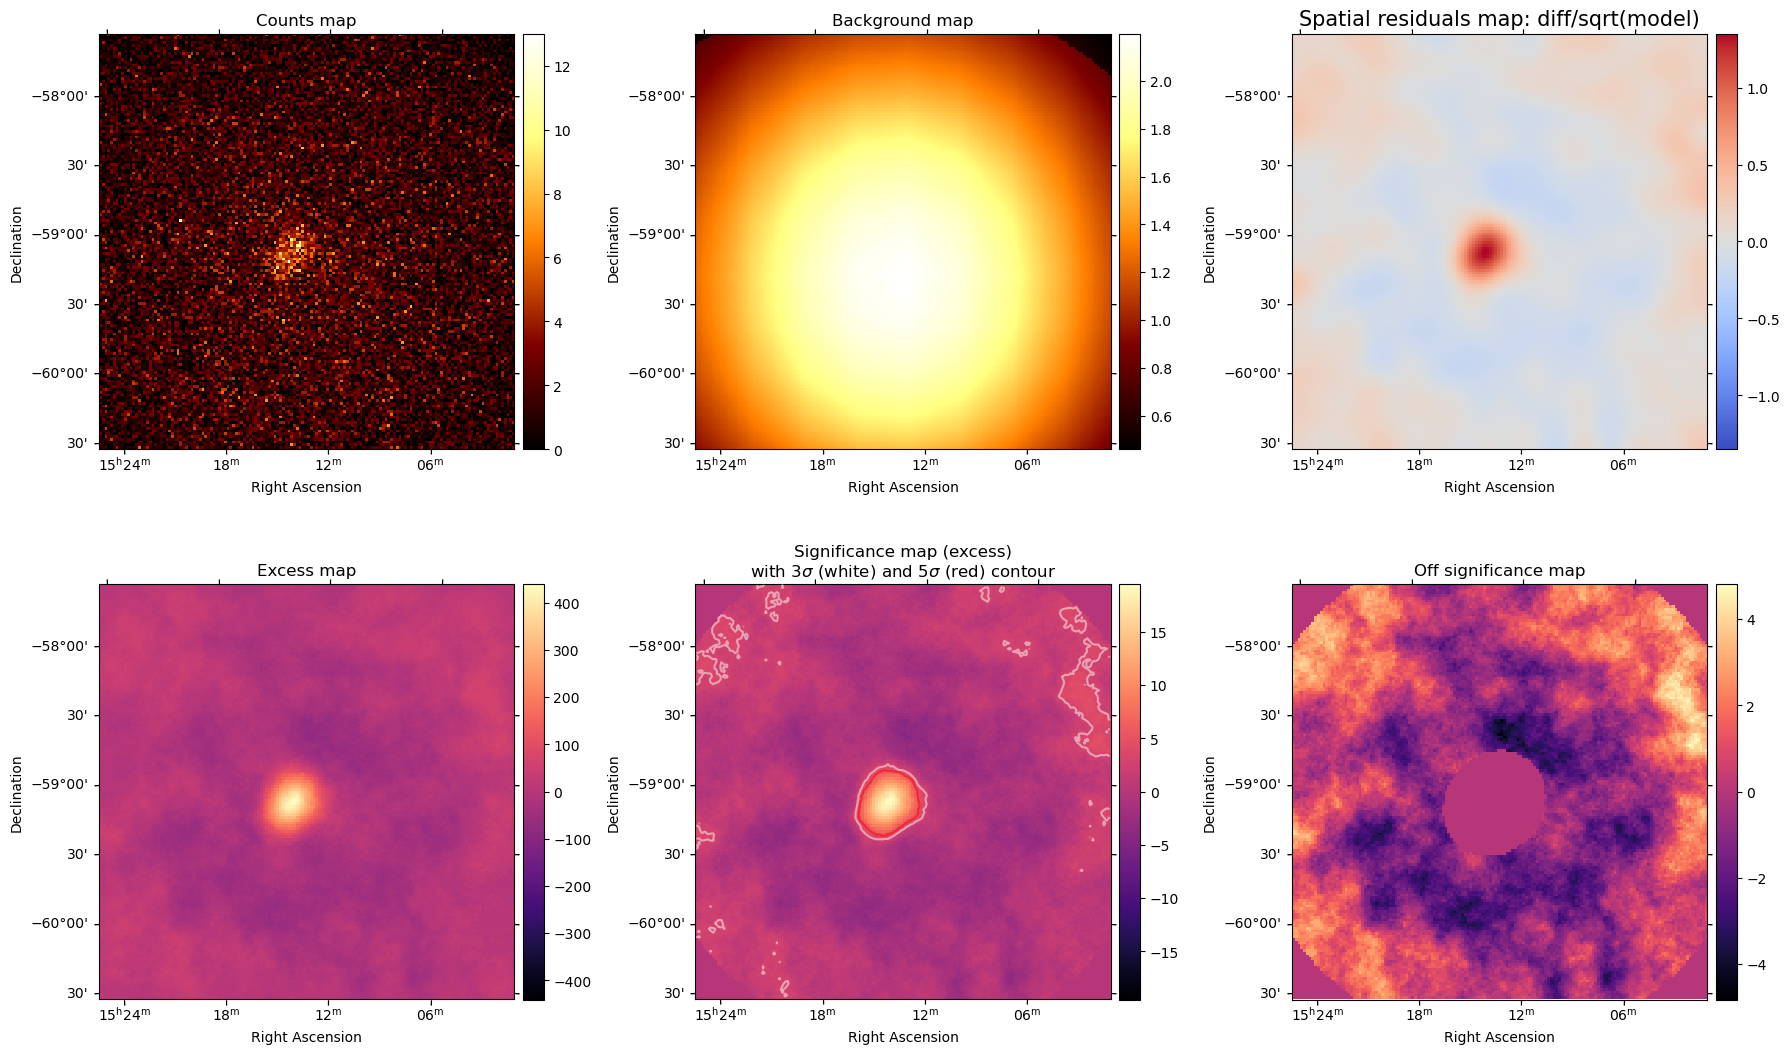

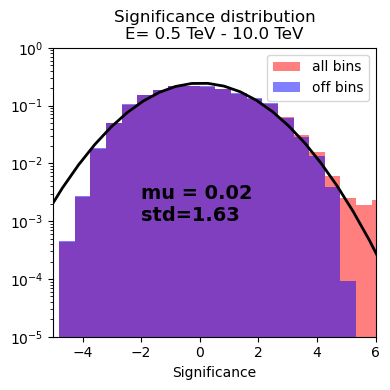

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000720374 is smaller than machine limit 0.00719636 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.000720374 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W DavidonErrorUpdator gvg <= 0 : cannot update - return same matrix
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


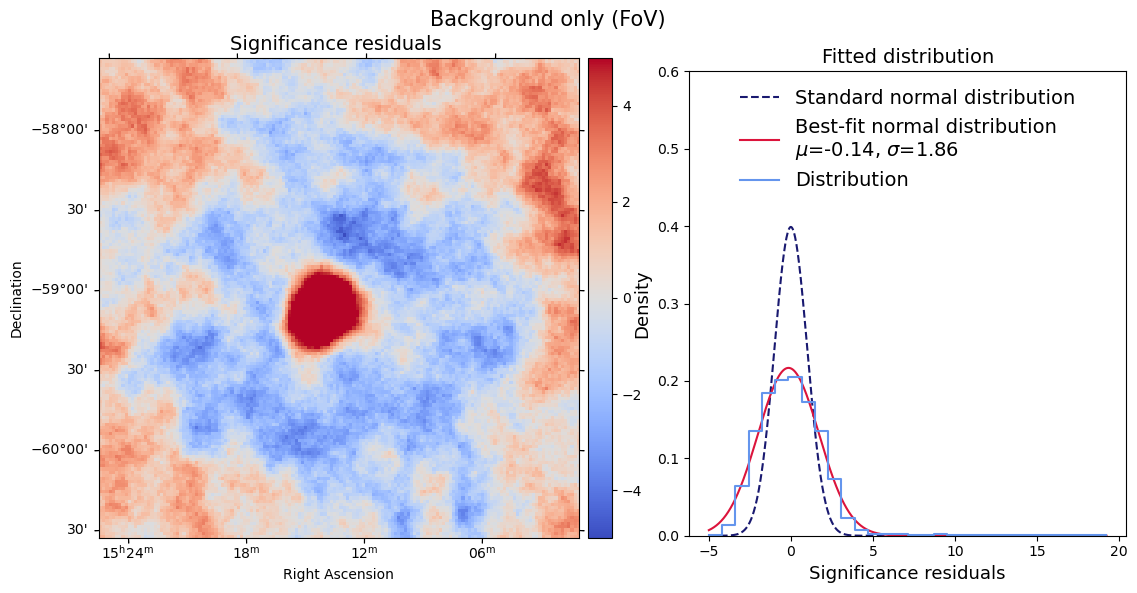

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 2.52143e-05 is smaller than machine limit 0.00717507 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 2.52143e-05 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W VariableMetricBuilder Reached machine accuracy limit; Edm 2.53731e-05 is smaller than machine limit 0.00717451 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 2.53731e-05 is above tolerance 2e-05
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 8.21398e-05 is smaller than machine limit 0.00717451 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 8.21398e-05 is above tolerance 2e-05
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 6.31189e-05 is smaller than machine limit 0.00717451 while 2e-

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


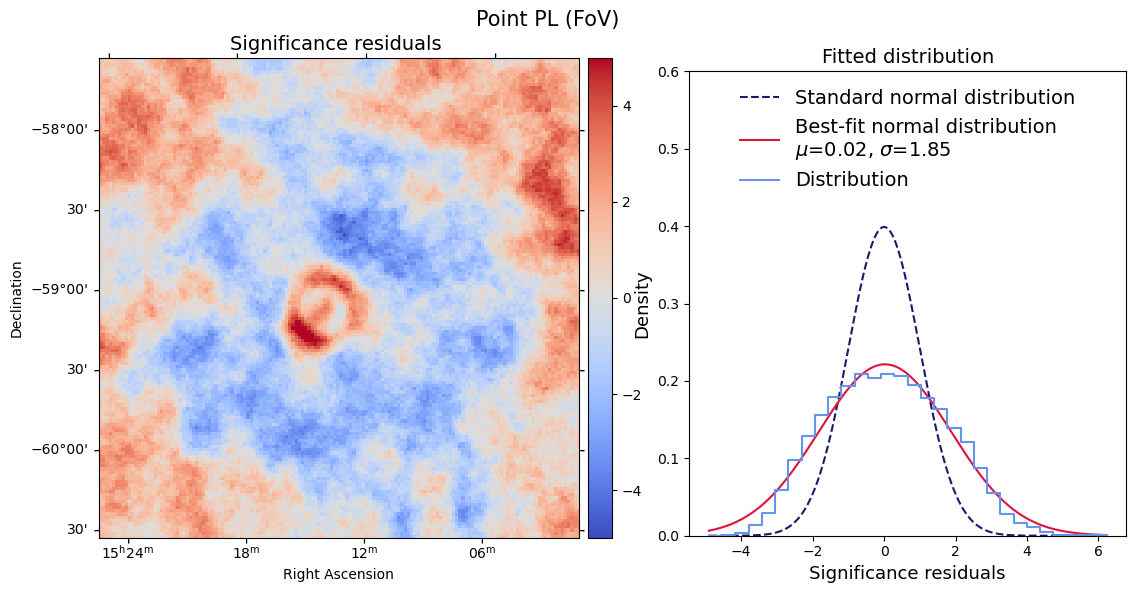

W MnPosDef Matrix forced pos-def by adding to diagonal 2.82013
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000724383 is smaller than machine limit 0.00716426 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.000724383 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0043467 is smaller than machine limit 0.00716426 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.0043467 is above tolerance 2e-05
W VariableMetricBuilder Reached machine accuracy limit; Edm 2.7993e-05 is smaller than machine limit 0.00716426 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 2.7993e-05 is above tolerance 2e-05
W DavidonErrorUpdator delgam < 0 : 

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


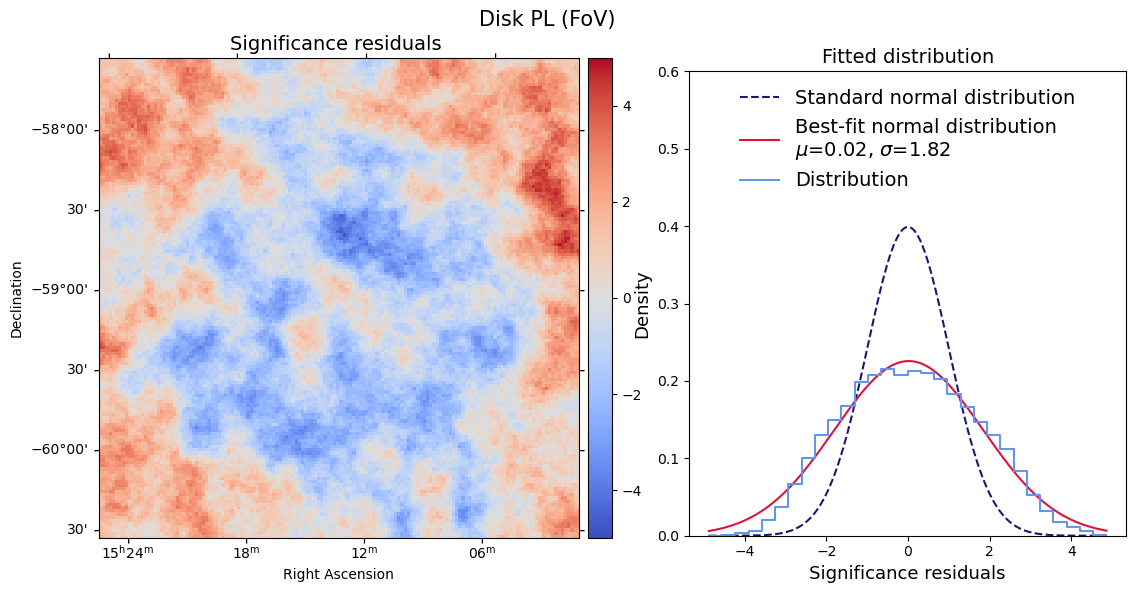

W MnPosDef Matrix forced pos-def by adding to diagonal 2.79334
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W MnPosDef Matrix forced pos-def by adding to diagonal 0.046801
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0439703
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0277486
W VariableMetricB

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


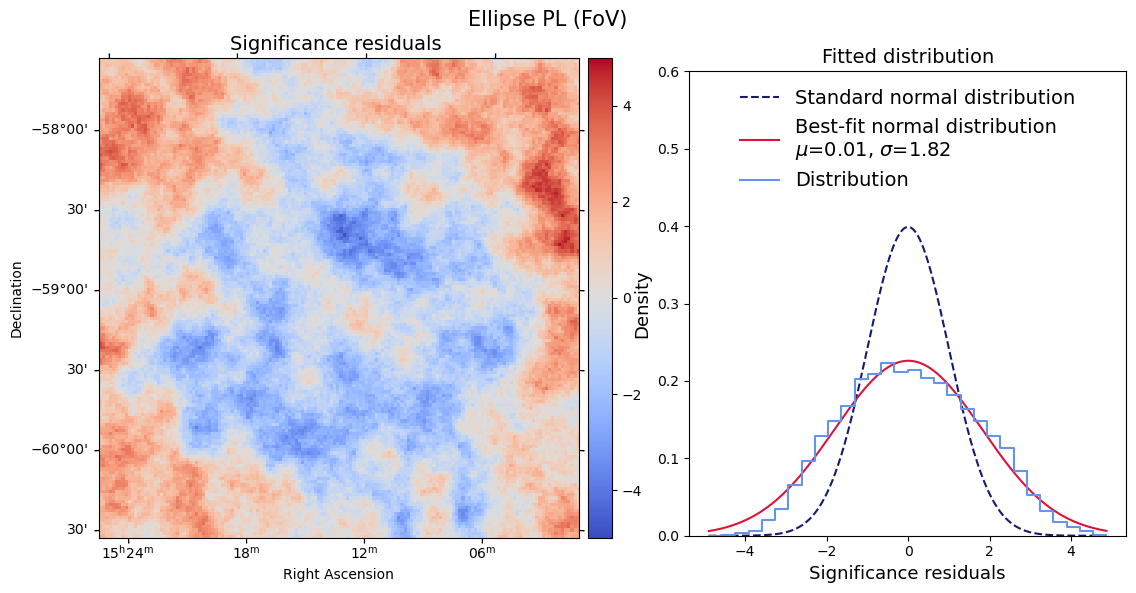

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00271552 is smaller than machine limit 0.00716441 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.00271552 is above tolerance 2e-05
W SimplexBuilder Simplex did not converge, edm > minedm
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 2.75464e-06 is smaller than machine limit 0.00716441 while 2e-06 was requested


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


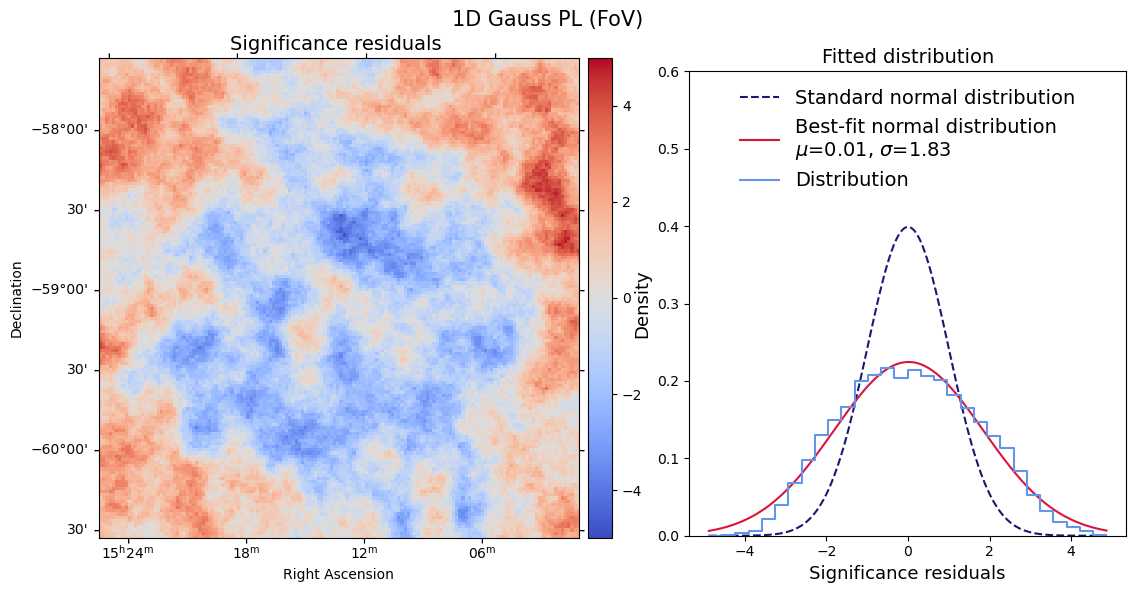

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0019428 is smaller than machine limit 0.00716431 while 2e-06 was requested
W VariableMetricBuilder No convergence; Edm 0.0019428 is above tolerance 2e-05
W VariableMetricBuilder Reached machine accuracy limit; Edm 3.2841e-06 is smaller than machine limit 0.00716431 while 2e-06 was requested


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


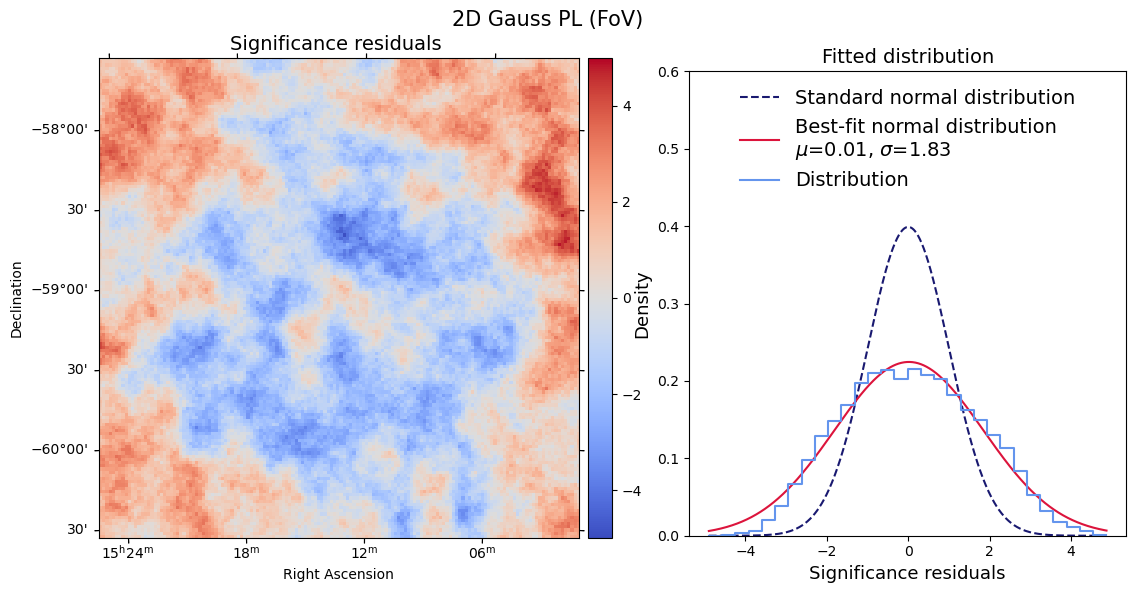

-----------------------------------------
----- Testing models as alternative -----

Tested model: Point PL
KEPT: More significant than all null models

Tested model: Disk PL
KEPT: More significant than all null models

Tested model: Ellipse PL
KEPT: More significant than all null models

Tested model: 1D Gauss PL
KEPT: More significant than all null models

Tested model: 2D Gauss PL
REMOVED: Not more significant than 1 null model

----- Testing remaining models as null -----

Tested model: Point PL
REMOVED: 4 more significant alternative models

Tested model: Disk PL
REMOVED: 1 more significant alternative models

Tested model: Ellipse PL
KEPT: No more significant alternative model

Tested model: 1D Gauss PL
KEPT: No more significant alternative model


model       wilk            AIC  relative_L
3   Ellipse PL  22.970479  120198.674915    1.000000
4  1D Gauss PL  22.650450  120218.879663    0.000041

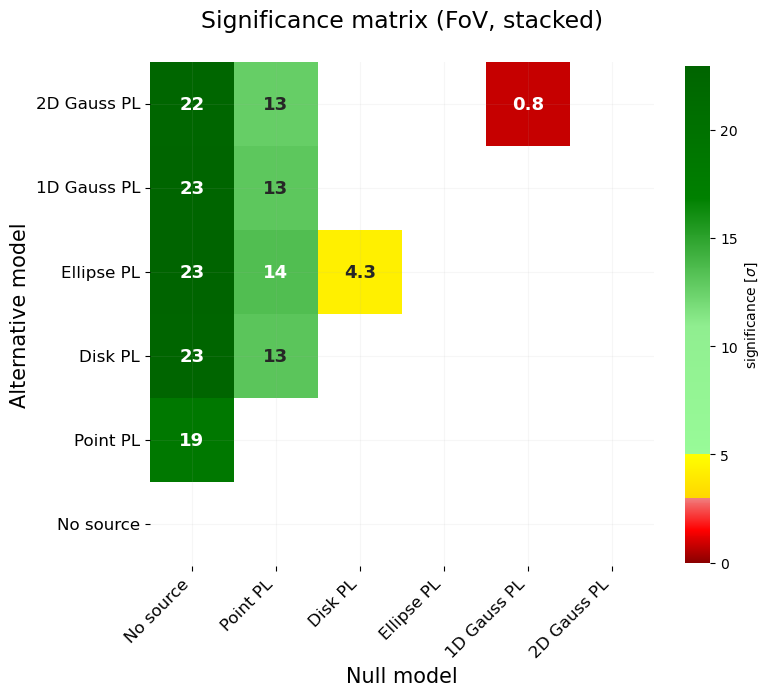

Pickle file saved at ./outputs/msh1552_hess/fit/3D_n_shapes_Ebins_7_offsetbins_8_offset_max_3.0_exclurad_0.8/hla/Eminmax_0.5_10_nbinEperdec_4_offmax_2.5_w_3_bkg_ring_FoV_fit_stacked/data/results_3d.pk


In [7]:
realbmv.init_hl_analysis()
analysis_dim=3
skymaps_arr = []
stacked_arr = []

do_analysis = True
overwrite = True
if do_analysis:
    for bkg_method in realbmv.cfg_hl_analysis["bkg_maker"]:
        results = realbmv.do_analysis(analysis_dim=analysis_dim, models_to_test=models_to_test, bkg_method=bkg_method, overwrite=overwrite)
        skymaps_arr.append(deepcopy(realbmv.skymaps_dict))
        stacked_arr.append(deepcopy(realbmv.stacked_dataset))
        any2pickle(f"{realbmv.data_dir_hla}/results_3d.pk", results)
else:
    realbmv.results_analysis = pickle2any(f"{realbmv.data_dir_hla}/results_3d.pk")
    for bkg_method in realbmv.cfg_hl_analysis["bkg_maker"]:
        realbmv.plot_skymaps(bkg_method, None if bkg_method == realbmv.cfg_hl_analysis["bkg_maker"][0] else 'stored')
        skymaps_arr.append(deepcopy(realbmv.skymaps_dict))
        stacked_arr.append(deepcopy(realbmv.stacked_dataset))
        realbmv.compute_dfmodels(bkg_method)

------------------ Best models for ring method ------------------


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


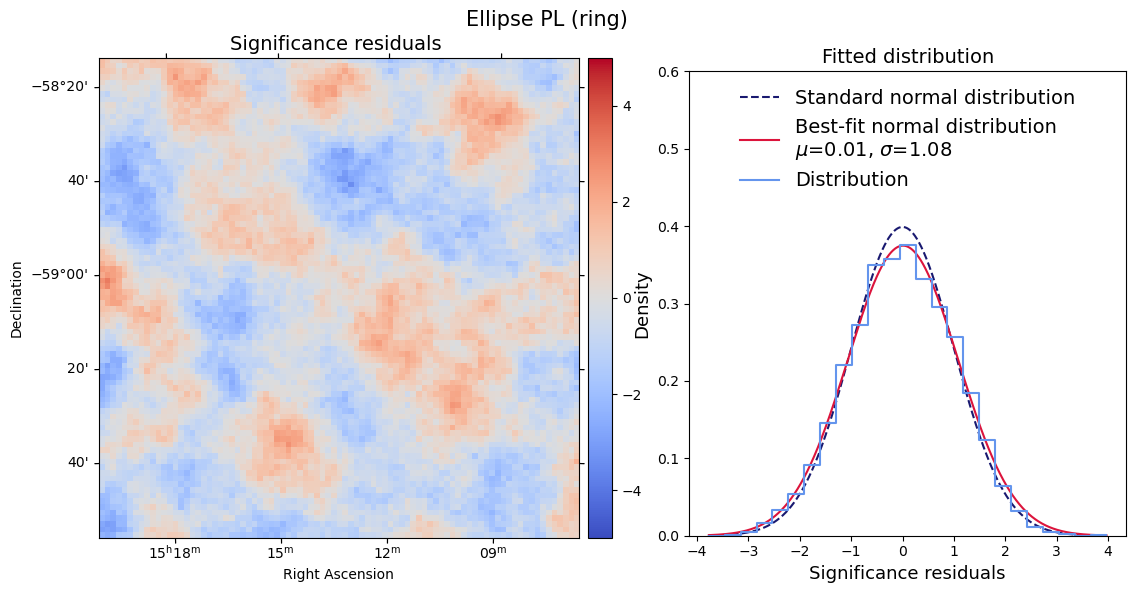

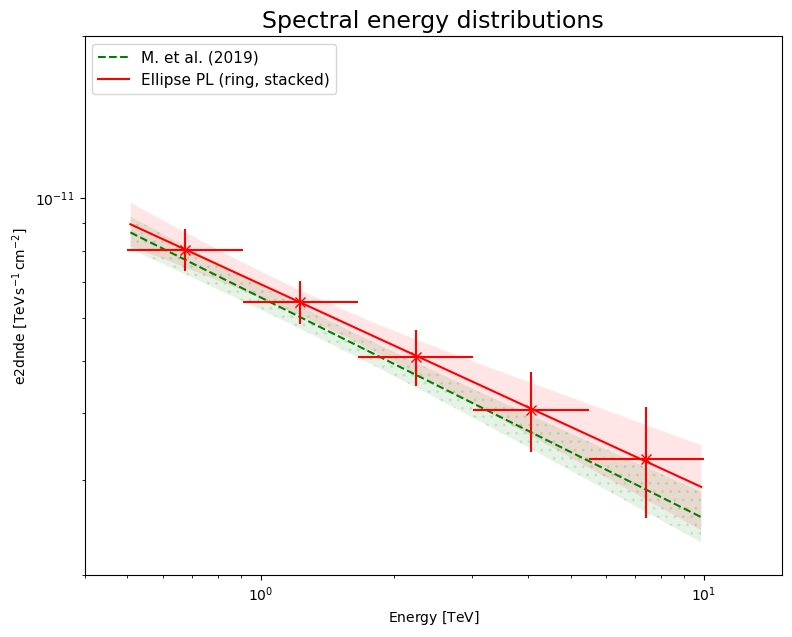

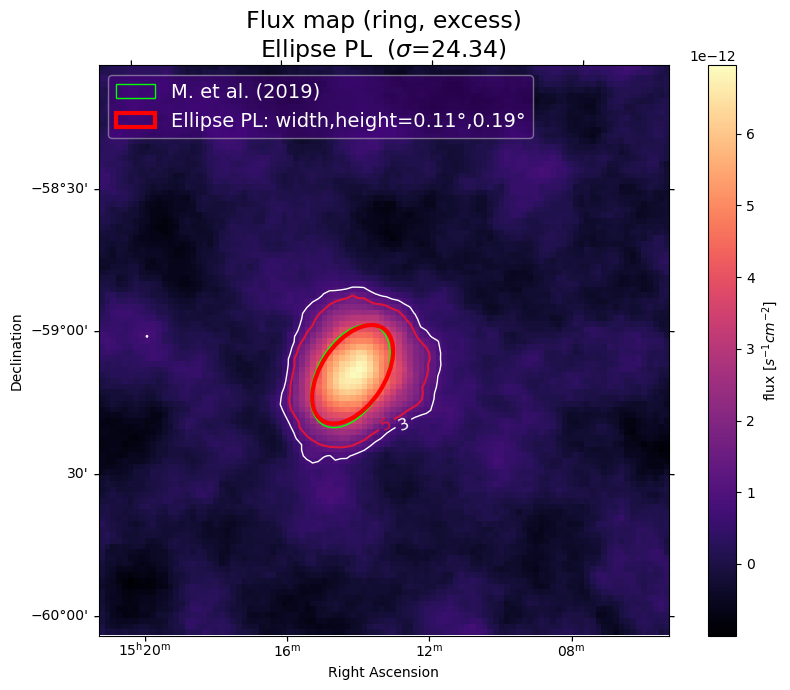

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


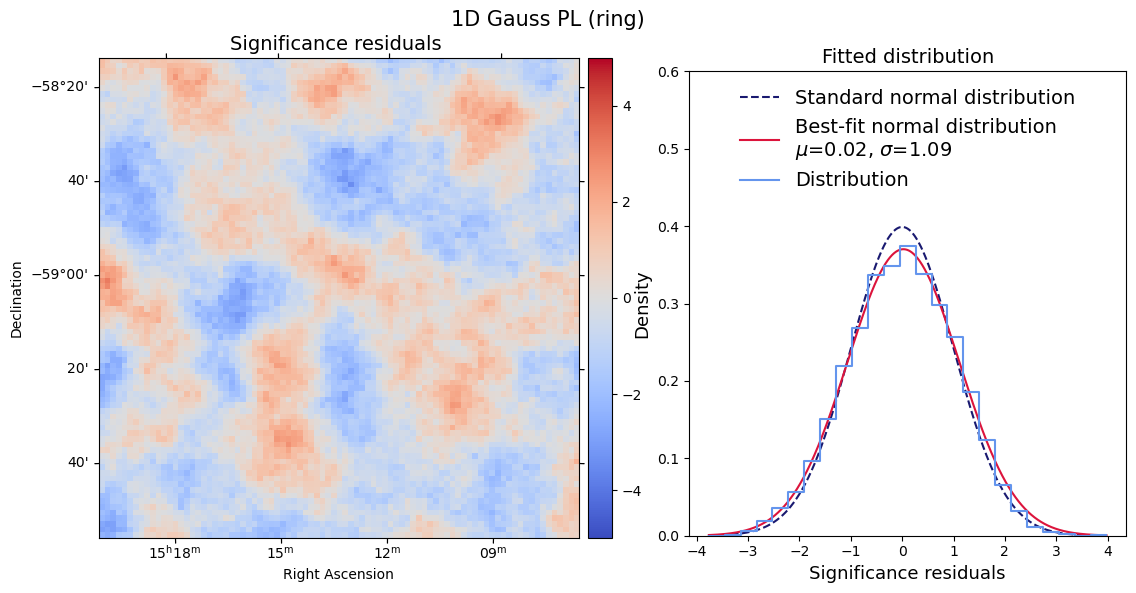

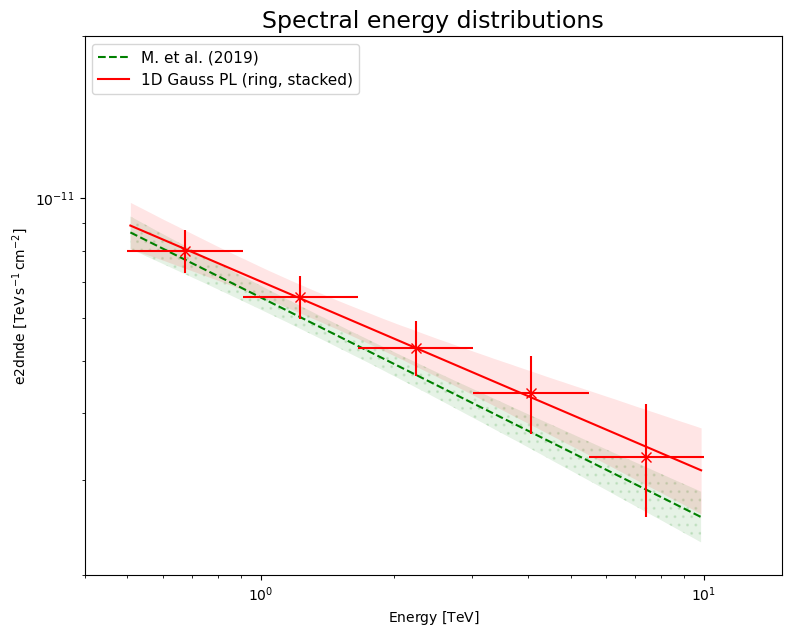

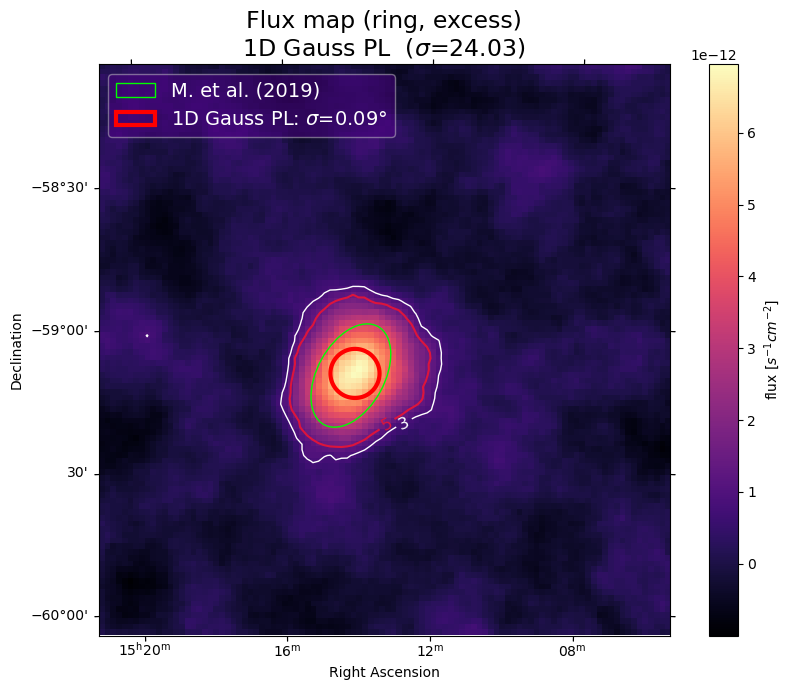

------------------ Best models for FoV method ------------------


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


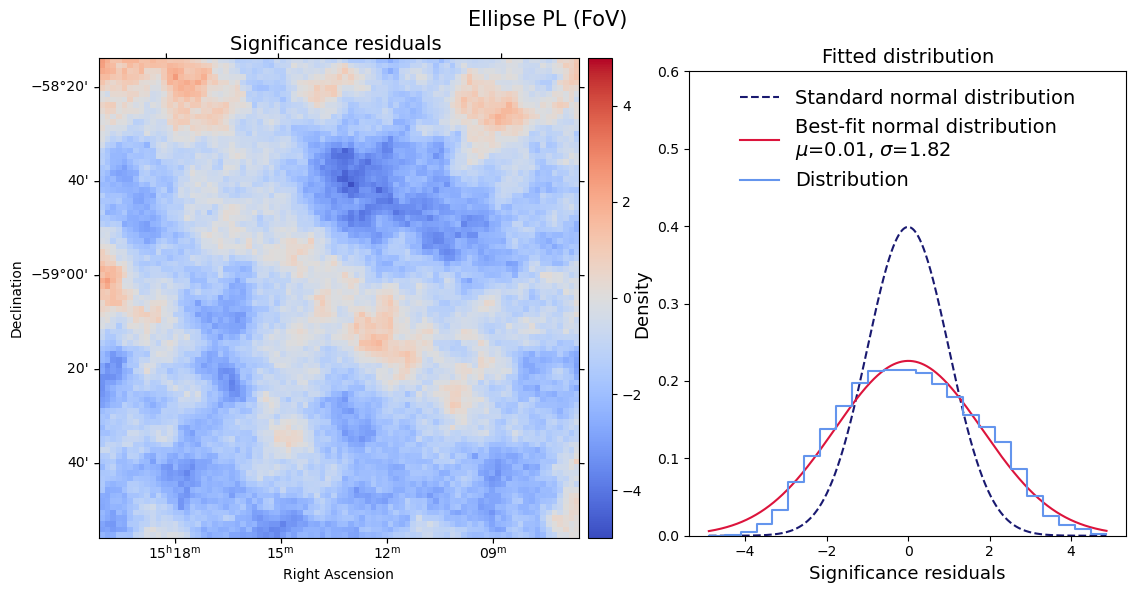

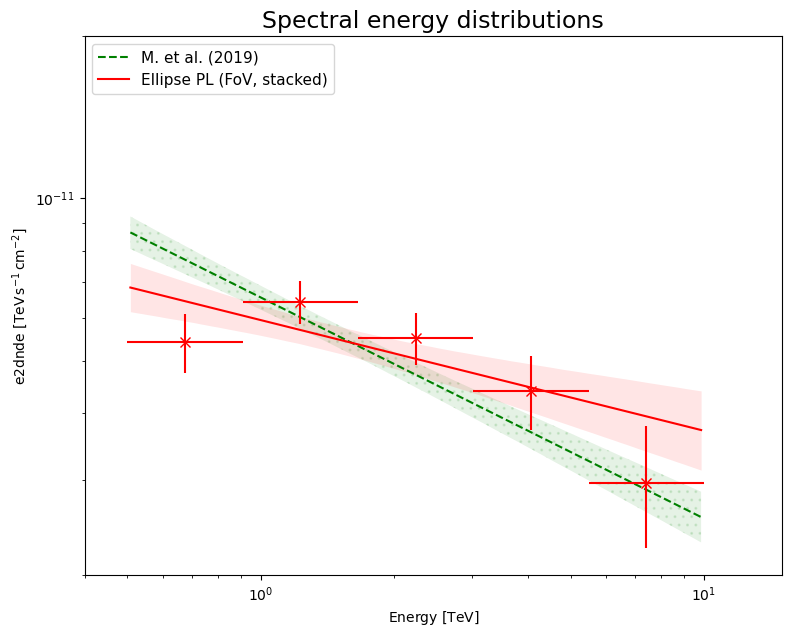

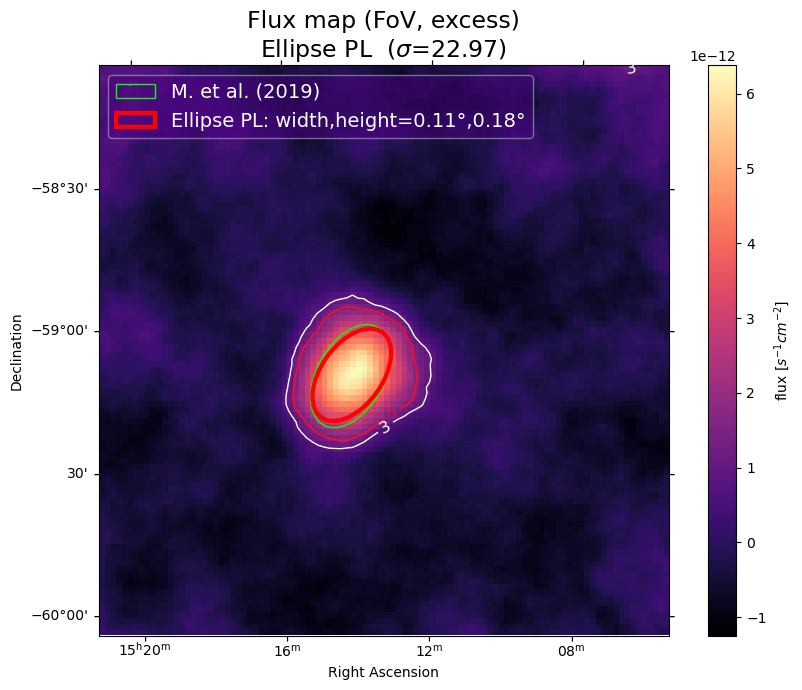

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


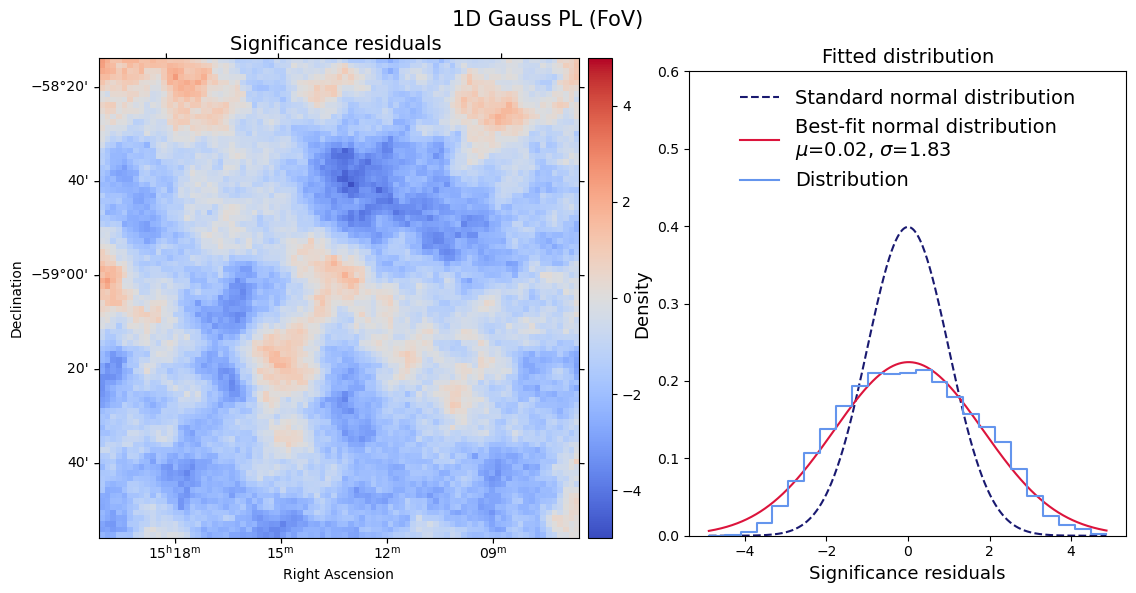

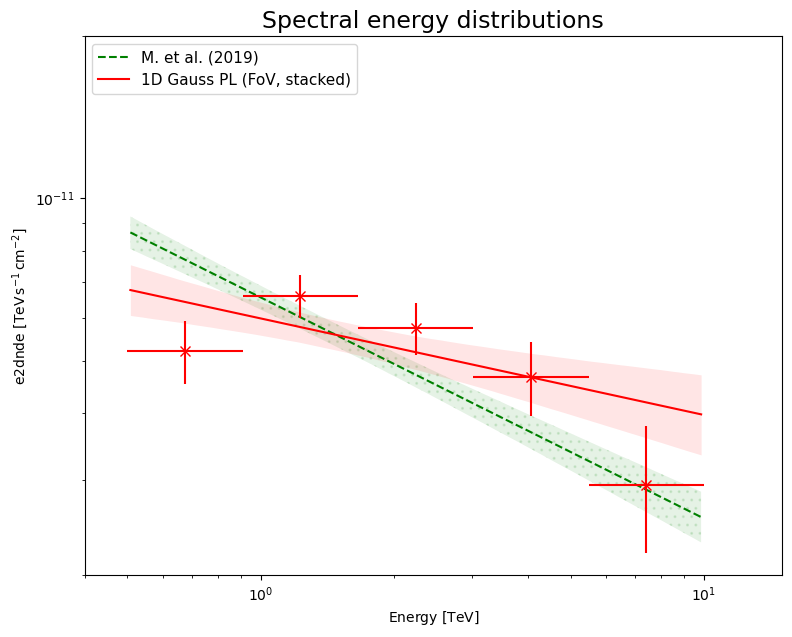

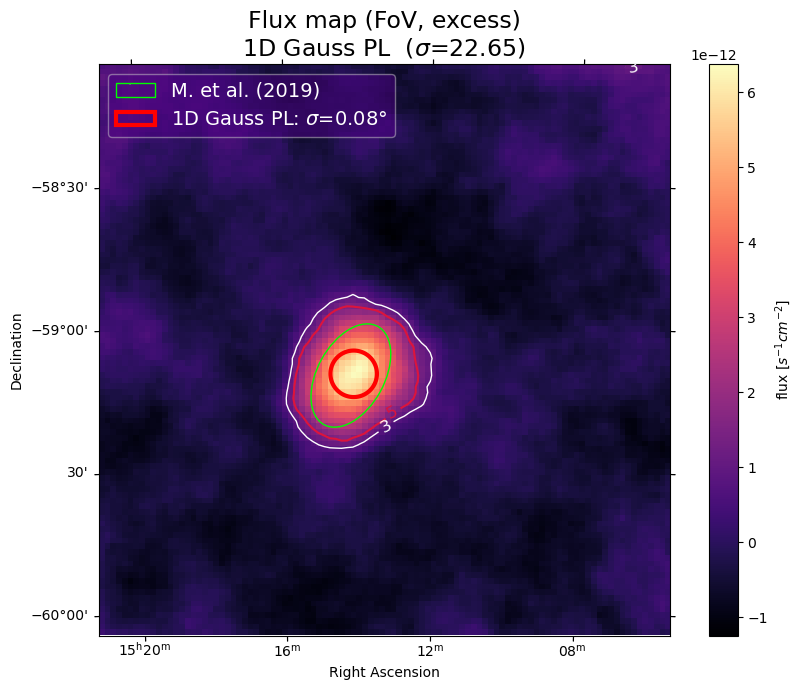

In [8]:
from toolbox import plot_significance_residuals, get_lima_maps
from hl_analysis import plot_spectra_from_models_dict, plot_spatial_model_from_dict

from gammapy.datasets import MapDataset,MapDatasetOnOff, Datasets
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator

ref_source_name = "MSH15-52"
realbmv.models_dict = load_yaml(realbmv.path_models)
ref_models_to_plot = ['hess']
ref_models = realbmv.models_dict.copy()

labelcolor_legend = "w"
facecolor_legend = "indigo"
alpha_legend = 0.5

color_ref = "lime"
lw_sigma = 2
alpha_sigma = 1

colors_contours = ["w", "crimson"]
alpha_contours = 1
lw_contours = [1, 1.5]

for ref_model in ref_models_to_plot:
    ref_models[ref_source_name]["published"][ref_model]["plot_kwargs"]["alpha_sigma"] = alpha_sigma
    ref_models[ref_source_name]["published"][ref_model]["plot_kwargs"]["color_sigma"] = color_ref
    ref_models[ref_source_name]["published"][ref_model]["plot_kwargs"]["lw_sigma"] = lw_sigma

fontsize,fontsize_map,bbox_to_anchor,figsize_map = 15,17,(1,1),(9,7)
figsize_residuals, width_left = (12,6),1.8
rel_L_tsh_arr = [100,100]
smooth=0.01

results_3d = deepcopy(realbmv.results_analysis)

for enum_bkg_method, rel_L_tsh, stacked in zip(enumerate(realbmv.hla_bkg_maker), rel_L_tsh_arr, stacked_arr):
    ibkg_method, bkg_method = enum_bkg_method
    # if bkg_method=='FoV': continue
    dfbest_models = realbmv.dfbest_models[bkg_method]
    stacked_dataset = Datasets()
    stacked_on_off = stacked.copy(name='stacked')
    if isinstance(stacked_on_off, MapDatasetOnOff): stacked_on_off = stacked_on_off.to_map_dataset(name=stacked_on_off.name)
    stacked_dataset.append(stacked_on_off.copy(name=stacked_on_off.name))
    
    models_list = dfbest_models[1].model.to_numpy()
    # models_list = models_to_test_names
    print(f"------------------ Best models for {bkg_method} method ------------------")
    for result_to_plot in models_list:
        colors=["red", "sandybrown","blue", "darkturquoise"]
        if all(c == "No source" for c in result_to_plot.split(" - ")): continue
        
        results_to_plot=[result_to_plot]
        bkg_methods_to_plot = [bkg_method]
        
        fit_methods_to_plot = [realbmv.hla_fit_method]
        model_str = ""
        res_key = 'results' if 'results' in results_3d[bkg_method].keys() else 'results_3d'
        models = results_3d[bkg_method][res_key][result_to_plot]["stacked"]["models"]
        for i, model in enumerate(models[:-1]):
            model_name = model.name
            model_str += (("" if i == 0 else " - ") + model_name[:-2])
        
        stacked_dataset.models = models.copy()

        lima_maps = get_lima_maps(deepcopy(stacked_dataset[0]), realbmv.correlation_radius, realbmv.correlate_off, estimator='excess', model_source=models)
        
        width = 2 *u.deg
        plot_significance_residuals(f"Significance residuals", deepcopy(lima_maps),title=f"{model_str} ({bkg_method})",figsize=figsize_residuals, width_left=width_left,n_bins=25,n_sigma=1, return_minmax=False)
        plt.show()
        
        fig, ax = plt.subplots(figsize=figsize_map)
        energy_bounds = [realbmv.hla_e_min, realbmv.hla_e_max]
        plot_spectra_from_models_dict(ax, results_3d, realbmv.models_dict, ref_source_name, ref_models_to_plot, analysis_dim=3, energy_bounds=energy_bounds, results_to_plot=results_to_plot, bkg_methods_to_plot=bkg_methods_to_plot, fit_methods_to_plot=fit_methods_to_plot, colors=colors)

        ax.legend(loc='upper left',fontsize=fontsize-4)
        xlim=[0.4,15]
        ylim = [2e-12,2e-11]
        ax.set(xlim=xlim,ylim=ylim)
        ax.set_title("Spectral energy distributions",fontsize=fontsize+2)
        plt.show()
        plot_spatial_model_from_dict(bkg_method, 'flux', results_3d, realbmv.models_dict, ref_source_name, ref_models_to_plot, results_to_plot=results_to_plot, bkg_methods_to_plot=bkg_methods_to_plot, fit_methods_to_plot=fit_methods_to_plot, estimator='excess', width=width, figsize=figsize_map, bbox_to_anchor=bbox_to_anchor, fontsize=fontsize_map, colors=colors,smooth=smooth)

------------------ Best models for ring method ------------------


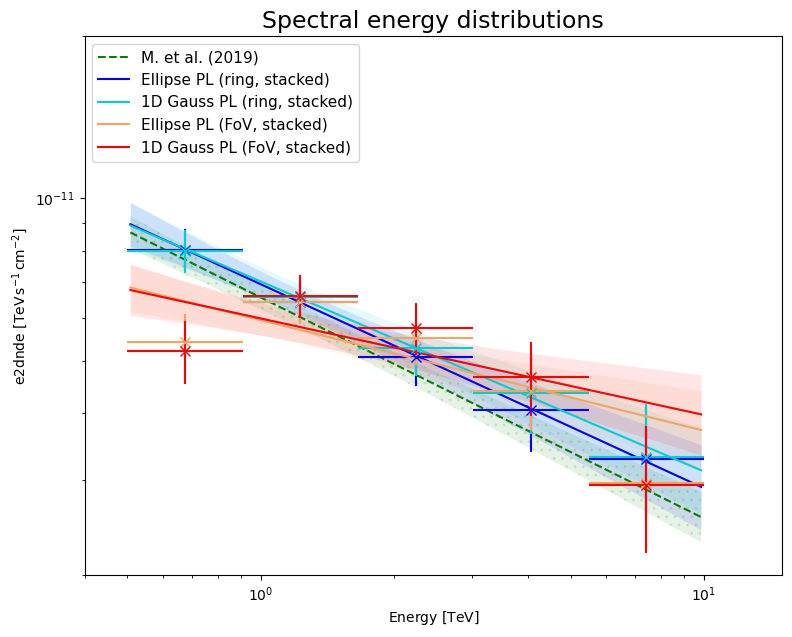

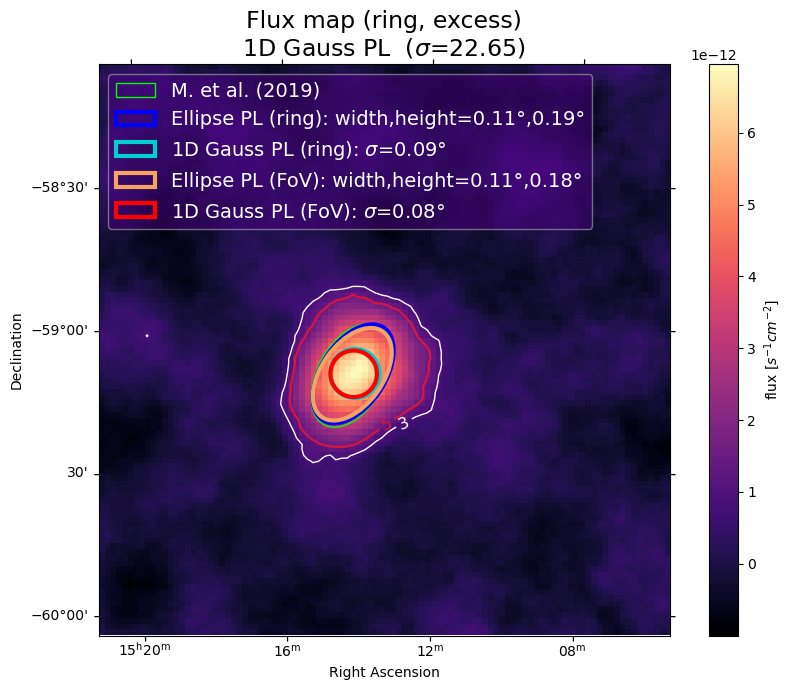

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


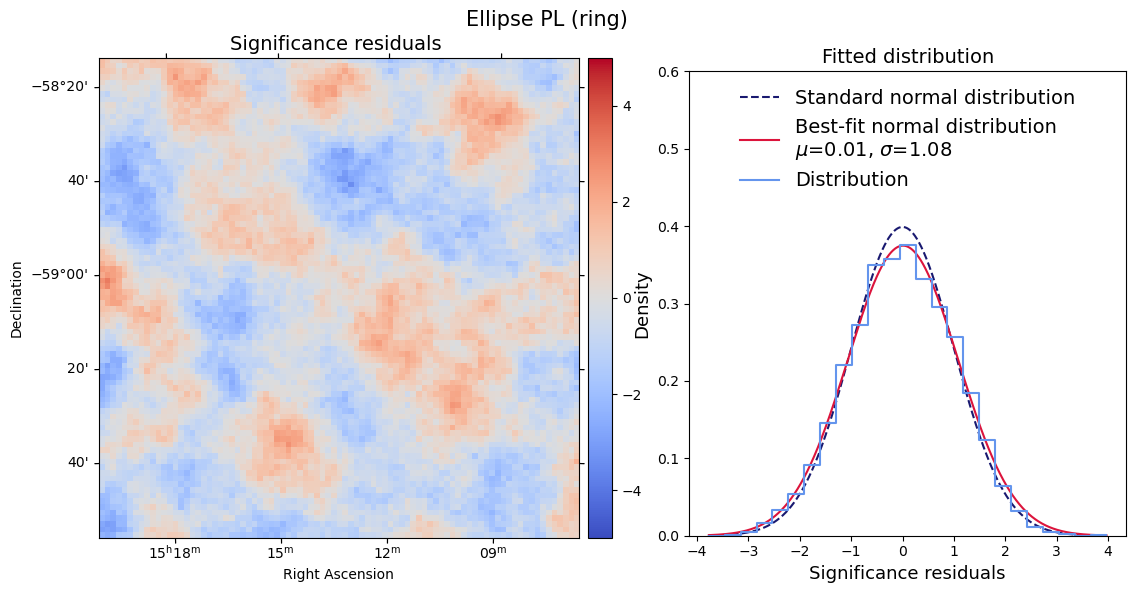

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


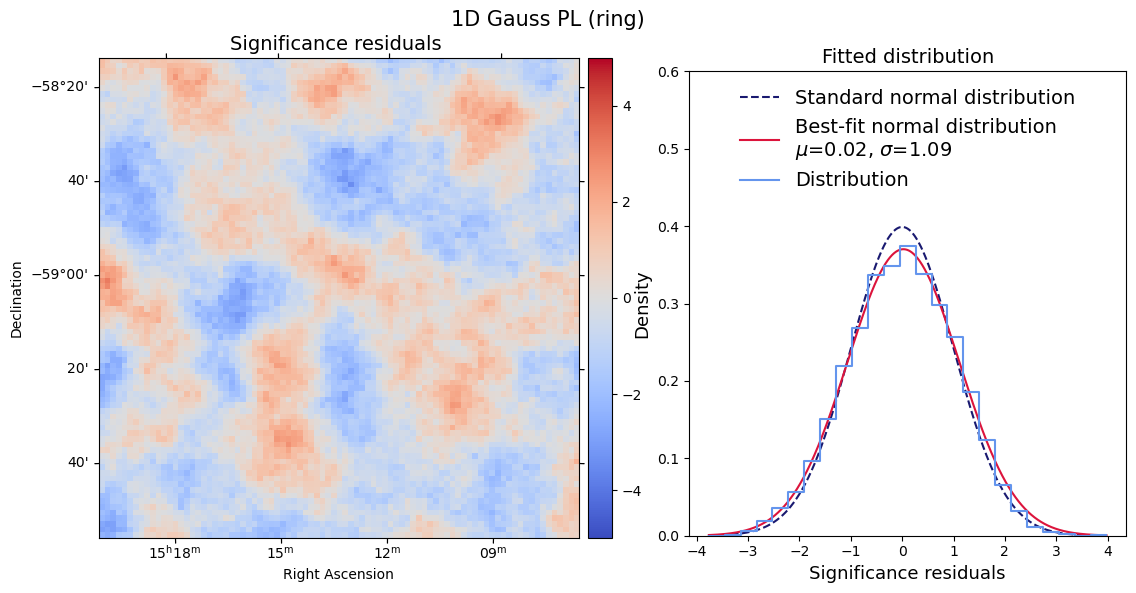

------------------ Best models for FoV method ------------------


/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


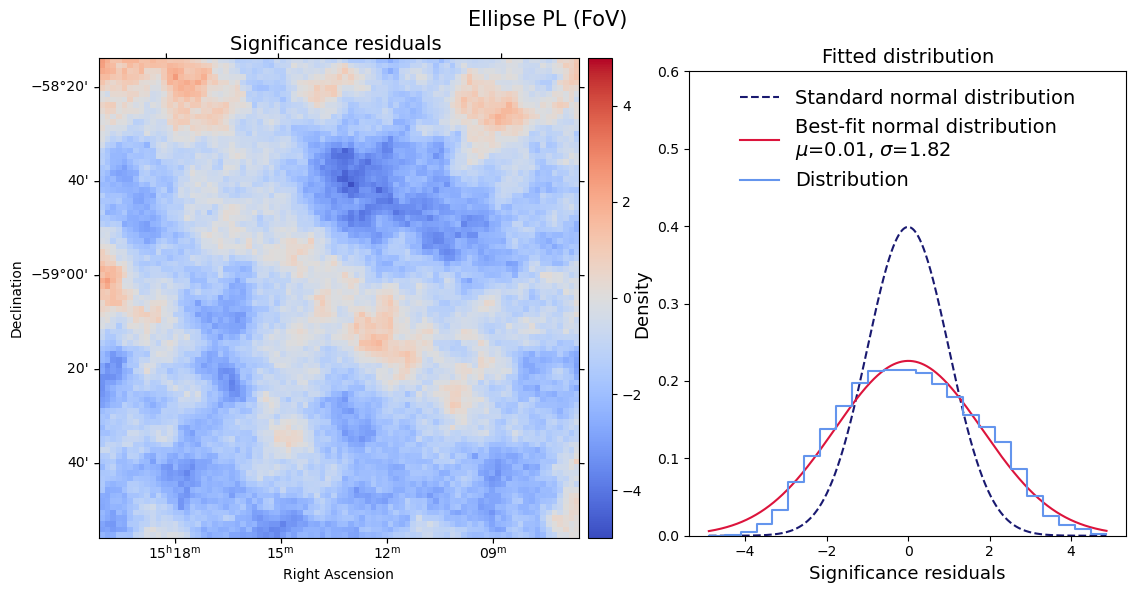

/Users/carrasco/Prog/gammapy/baccmod_paper/SimBMVtool/SimBMVtool/./toolbox.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


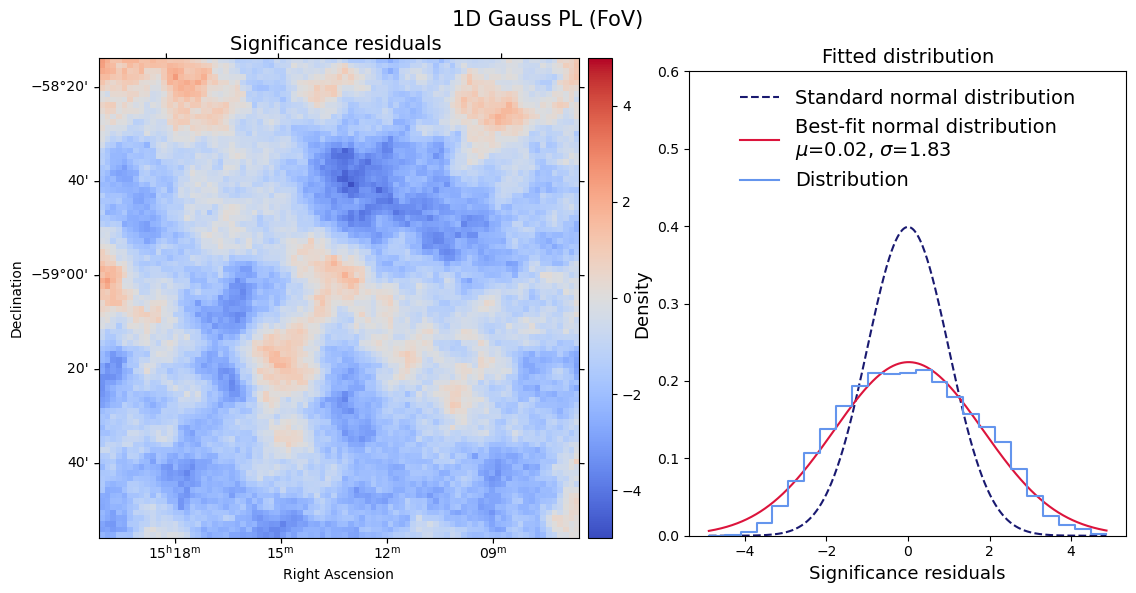

In [9]:
# Plot every result on the same SED and skymap plots, and residuals on separate plots

for enum_bkg_method, rel_L_tsh, stacked in zip(enumerate(realbmv.hla_bkg_maker), rel_L_tsh_arr, stacked_arr):
    ibkg_method, bkg_method = enum_bkg_method
    dfbest_models = realbmv.dfbest_models[bkg_method]
    stacked_dataset = Datasets()
    stacked_on_off = stacked.copy(name='stacked')
    if isinstance(stacked_on_off, MapDatasetOnOff): stacked_on_off = stacked_on_off.to_map_dataset(name=stacked_on_off.name)
    stacked_dataset.append(stacked_on_off.copy(name=stacked_on_off.name))
    
    models_list = dfbest_models[1].model.to_numpy()
    # models_list = models_to_test_names
    # models_list = ["1D Gauss PL", "Disk PL"]
    print(f"------------------ Best models for {bkg_method} method ------------------")
    for iresult, result_to_plot in enumerate(models_list):
        if all(c == "No source" for c in result_to_plot.split(" - ")): continue
        results_to_plot=[result_to_plot]
        colors=["blue", "darkturquoise", "sandybrown", "red"]
        bkg_methods_to_plot = [bkg_method]
        fit_methods_to_plot = [realbmv.hla_fit_method]
        model_str = ""
        res_key = 'results' if 'results' in results_3d[bkg_method].keys() else 'results_3d'
        models = results_3d[bkg_method][res_key][result_to_plot]["stacked"]["models"]
        if (ibkg_method==0) and (iresult==0):
            fig, ax = plt.subplots(figsize=figsize_map)
            energy_bounds = [realbmv.hla_e_min, realbmv.hla_e_max]
            plot_spectra_from_models_dict(ax, results_3d, realbmv.models_dict, ref_source_name, ref_models_to_plot, analysis_dim=3, energy_bounds=energy_bounds, results_to_plot=models_list, bkg_methods_to_plot=realbmv.hla_bkg_maker, fit_methods_to_plot=fit_methods_to_plot, colors=colors)

            ax.legend(loc='upper left',fontsize=fontsize-4)
            xlim=[0.4,15]
            ylim = [2e-12,2e-11]
            ax.set(xlim=xlim,ylim=ylim)
            ax.set_title("Spectral energy distributions",fontsize=fontsize+2)
            plt.show()
            plot_spatial_model_from_dict(bkg_method, 'flux', results_3d, realbmv.models_dict, ref_source_name, ref_models_to_plot, results_to_plot=models_list, bkg_methods_to_plot=realbmv.hla_bkg_maker, fit_methods_to_plot=fit_methods_to_plot, estimator='excess', width=width, figsize=figsize_map, bbox_to_anchor=bbox_to_anchor, fontsize=fontsize_map, colors=colors,smooth=smooth)
            plt.show()

        for i, model in enumerate(models[:-1]):
            model_name = model.name
            model_str += (("" if i == 0 else " - ") + model_name[:-2])
        
        stacked_dataset.models = models.copy()

        lima_maps = get_lima_maps(deepcopy(stacked_dataset[0]), realbmv.correlation_radius, realbmv.correlate_off, estimator='excess', model_source=models)
        
        width = 2 *u.deg
        plot_significance_residuals(f"Significance residuals", deepcopy(lima_maps),title=f"{model_str} ({bkg_method})",figsize=figsize_residuals, width_left=width_left,n_bins=25,n_sigma=1, return_minmax=False)
        plt.show()